<a href="https://colab.research.google.com/github/peeyushsinghal/da/blob/main/mitigating_bias_sa_da_v26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mitigating bias in sentiment analysis using domain adaptation

In [1]:
! pip install torchtext==0.10.0 --quiet # DOWNGRADE YOUR TORCHTEXT
! pip install ekphrasis --quiet # library to pre process twitter data
! pip install emoji --upgrade --quiet #library to deal with emoji data

In [2]:
## Import statements
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.legacy.data import Dataset, Field, TabularDataset, BucketIterator
from torchtext.vocab import GloVe
import torchtext.vocab as vocab
import numpy as np
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import emoji
from torchtext.legacy.vocab import Vectors
from tqdm import tqdm
import random
import torch.optim as optim
import scipy.stats as stats
from statistics import mean

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

import time

from copy import deepcopy

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import matplotlib.pyplot as plt
# import EarlyStopping
# from pytorchtools import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# checking device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:{}".format(DEVICE))

Running on:cuda


## Data loading

In [4]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Configuration

In [5]:

BASE_PATH = '/content/drive/MyDrive/semeval-2018'

DATA_DIR = os.path.join(BASE_PATH,'datasets')
TARGET_DIR = os.path.join(BASE_PATH,'targetdataset')

MODEL_DIR = os.path.join(BASE_PATH,'models')
REF_DIR = os.path.join(BASE_PATH,'reference')
EMBEDDINGS_DIR = os.path.join(BASE_PATH,'embeddings')

MAX_SIZE = 50
MAX_VOCAB_SIZE = 10000
BATCH_SIZE = 8

EMBEDDING_TO_BE_USED = 'glove' # {'glove', 'glove_gn'}
TARGET_BATCH_SIZE = 8

NUM_EPOCHS = 100
# NUM_EPOCHS = 2
# NUM_EPOCHS = 50
LR = 2e-4

PATIENCE = 10
EWC_LAMBDA = 0.4

if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
  print("The new directory is created!")


BONFERRONI_CORRECTION = 5.0

In [6]:
# data configuration

class TASK1(object):
  
    EI_reg = {
        'anger': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-anger-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-anger-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-anger-test-gold.txt')
                },
        'joy': {
                'train': os.path.join(
                    DATA_DIR, 'task1/EI-reg/training/EI-reg-En-joy-train.txt'),
                'dev': os.path.join(
                    DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-joy-dev.txt'),
                'gold': os.path.join(
                    DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-joy-test-gold.txt')
                },
        'fear': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-fear-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-fear-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-fear-test-gold.txt')
                },
        'sadness': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-sadness-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-sadness-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-sadness-test-gold.txt')
                }                     
        }

    V_reg = {
        'train': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-train.txt'),
        'dev': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-dev.txt'),
        'gold': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-test-gold.txt')
             }

    EEC = {
        'eec': os.path.join(
            DATA_DIR, 'task1/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')
             }

## Source Data
Parsing Emotion and Valence regression data : `format [ID	Tweet	Affect Dimension	Intensity Score]`

In [7]:
def parse_reg(data_file, label_format='tuple'):
    """
    This is for datasets for the EI-reg and V-reg English tasks 
    Returns:
        df: dataframe with columns in the first row of file [ID-Tweet-Affect Dimension-Intensity Score]
    """
    with open(data_file, 'r') as fd:
      data = [l.strip().split('\t') for l in fd.readlines()]
    # print(data)
    df = pd.DataFrame (data[1:],columns=data[0])
    csv_file_name = (data_file.split("/")[-1]).split('.')[0]+".csv"
    csv_file = df.to_csv(str(csv_file_name))
    return csv_file_name


Generic Source Data Parser

In [8]:
def parse_csv(task, dataset, emotion='anger'):
    if task == 'EI-reg':
        data_train = TASK1.EI_reg[emotion][dataset]
        csv_file_name = parse_reg(data_train)
        return csv_file_name

    elif task == 'V-reg':
        data_train = TASK1.V_reg[dataset]

        csv_file_name = parse_reg(data_train)
        return csv_file_name

    else:
        return None

In [9]:
emotions = ['anger','joy','fear','sadness']
dict_data ={'train':'train','dev':'val','gold':'test'}
dict_file_name ={}
for emotion in emotions:
  for data_info, data_usage in dict_data.items():
    file_name = str('file_EI_'+ emotion + "_" + data_usage)
    dict_file_name[file_name] = parse_csv('EI-reg', data_info, emotion)

    file_name2 = str('file_V_'+ data_usage)
    dict_file_name[file_name2] = parse_csv('V-reg', data_info)

(dict_file_name)

{'file_EI_anger_train': 'EI-reg-En-anger-train.csv',
 'file_V_train': '2018-Valence-reg-En-train.csv',
 'file_EI_anger_val': '2018-EI-reg-En-anger-dev.csv',
 'file_V_val': '2018-Valence-reg-En-dev.csv',
 'file_EI_anger_test': '2018-EI-reg-En-anger-test-gold.csv',
 'file_V_test': '2018-Valence-reg-En-test-gold.csv',
 'file_EI_joy_train': 'EI-reg-En-joy-train.csv',
 'file_EI_joy_val': '2018-EI-reg-En-joy-dev.csv',
 'file_EI_joy_test': '2018-EI-reg-En-joy-test-gold.csv',
 'file_EI_fear_train': 'EI-reg-En-fear-train.csv',
 'file_EI_fear_val': '2018-EI-reg-En-fear-dev.csv',
 'file_EI_fear_test': '2018-EI-reg-En-fear-test-gold.csv',
 'file_EI_sadness_train': 'EI-reg-En-sadness-train.csv',
 'file_EI_sadness_val': '2018-EI-reg-En-sadness-dev.csv',
 'file_EI_sadness_test': '2018-EI-reg-En-sadness-test-gold.csv'}

## Preprocess tweets

In [10]:
# reference : https://github.com/cbaziotis/ekphrasis


text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


In [11]:
def preprocess_tweet(tweet): 
  tweet_processed = text_processor.pre_process_doc(tweet)
  # print (tweet_processed)
  demojized_list =[]
  final_list =[]
  for index, tweet in enumerate(tweet_processed):
      demojized_list.append(emoji.demojize(tweet, language = 'en'))
  final_list = [w for w in demojized_list if w not in en_stops] 
  
  # print(df)
  return final_list

## TorchText Treatment

In [12]:
dict_file_name.keys()

dict_keys(['file_EI_anger_train', 'file_V_train', 'file_EI_anger_val', 'file_V_val', 'file_EI_anger_test', 'file_V_test', 'file_EI_joy_train', 'file_EI_joy_val', 'file_EI_joy_test', 'file_EI_fear_train', 'file_EI_fear_val', 'file_EI_fear_test', 'file_EI_sadness_train', 'file_EI_sadness_val', 'file_EI_sadness_test'])

In [13]:
dict_fields ={}
list_name = list(set(["_".join(key.split("_")[1:-1]) for key in list(dict_file_name.keys())]))


for name in list_name:
  field_tweet = Field(sequential=True, 
                      use_vocab = True, 
                      tokenize = preprocess_tweet, 
                      fix_length = MAX_SIZE, 
                      batch_first = True)
  field_intensity = Field(sequential= False, 
                        dtype = torch.float,
                        use_vocab = False)
  fields = {
    'Tweet':('tweet', field_tweet ), #
    'Intensity Score': ('intensity',field_intensity) # Intensity Score is name of the dataset column, field_intensity is how we have defined the field, intensity is the name of the variable going fwd
    }
  
  dict_fields[name] = fields

dict_fields

{'V': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7fd6a5f637c0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7fd6a5f635e0>)},
 'EI_joy': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7fd6a5f63610>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7fd6a5f63640>)},
 'EI_sadness': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7fd6a5f636a0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7fd6a5f636d0>)},
 'EI_anger': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7fd6a5f63700>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7fd6a5f63730>)},
 'EI_fear': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7fd6a5f63760>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7fd6a5f63790>)}}

In [14]:
dict_fields['EI_sadness']['Tweet'][1]

In [15]:
dict_dataset ={}
for file_key, file_name in dict_file_name.items():
  # print(file_key,file_name)
  if "train" in (file_key.split("_")[-1]):
    head_name = "_".join(file_key.split("_")[0:-1])
    base_name = "_".join(file_key.split("_")[1:-1])
    # print(base_name)
    train_file = dict_file_name[head_name+"_train"]
    val_file = dict_file_name[head_name+"_val"]
    test_file =  dict_file_name[head_name+"_test"]

    train, val, test =TabularDataset.splits( path = './', 
                                            train = train_file, 
                                            validation = val_file, 
                                            test = test_file,
                                            format = 'csv', 
                                            fields = dict_fields[base_name])
    
  
    dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}

In [16]:
dict_dataset

{'EI_anger': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6a5f5f610>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6a5f5f4f0>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6a5da8400>},
 'V': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6d747a490>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6a4fd5ca0>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6a48461f0>},
 'EI_joy': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6a411cb20>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6a3f29c40>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6a3a39f40>},
 'EI_fear': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6a376db20>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fd6a3688a30>,
  'test_dataset': <torchtext.legacy

In [17]:
for key, value in dict_dataset.items():
  # count = 0
  for name, dataset in value.items():
    for example in dataset.examples:
      print(key, name, example.tweet, example.intensity)
      break


EI_anger train_dataset ['<user>', '<user>', 'shut', 'hashtags', 'cool', '<hashtag>', 'offended', '</hashtag>'] 0.562
EI_anger val_dataset ["'", 'need', 'something', '.', 'something', 'must', 'done', '!', '<repeated>', "'", '\\', 'n', '\\', 'nyour', 'anxiety', 'amusing', '.', 'nothing', 'done', '.', 'despair', '.'] 0.517
EI_anger test_dataset ['<user>', 'know', 'mean', 'well', 'offended', '.', 'prick', '.'] 0.734
V train_dataset ['<user>', 'yeah', '!', '<happy>', 'playing', 'well'] 0.600
V val_dataset ['<user>', 'site', 'crashes', 'everytime', 'try', 'book', '-', 'help', '?', 'tell', "'", 'nothing', 'wrong', '&', 'hang', '<hashtag>', 'furious', '</hashtag>', '<hashtag>', 'helpless', '</hashtag>', '<user>'] 0.141
V test_dataset ['gm', '<hashtag>', 'tuesday', '</hashtag>', '!'] 0.589
EI_joy train_dataset ['<user>', 'quite', 'saddened', '.', '<repeated>', 'us', 'dates', ',', 'joyous', 'anticipation', 'attending', 'dg', 'concert', '(', 'since', '<number>', ')', '.', 'happy', 'keeping', 'bus

## Building iterator and Vocabulary

In [18]:
for name, value in dict_fields.items():
  print(name, value)

V {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fd6a5f637c0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fd6a5f635e0>)}
EI_joy {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fd6a5f63610>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fd6a5f63640>)}
EI_sadness {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fd6a5f636a0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fd6a5f636d0>)}
EI_anger {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fd6a5f63700>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fd6a5f63730>)}
EI_fear {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fd6a5f63760>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fd6a5f63790>)}


In [19]:
dict_emb_file = {'glove':'glove.6B.300d.txt',
                 'glove_gn': '1b-vectors300-0.8-0.8.txt'}

print("EMBEDDING_TO_BE_USED:", EMBEDDING_TO_BE_USED)
emb_file_path = os.path.join(EMBEDDINGS_DIR ,dict_emb_file[EMBEDDING_TO_BE_USED])
emb_file_path

EMBEDDING_TO_BE_USED: glove


'/content/drive/MyDrive/semeval-2018/embeddings/glove.6B.300d.txt'

In [20]:

for name, value in dict_fields.items():
  print(name, value['Tweet'][1])
  
  ## start for embeddings from text file
  value['Tweet'][1].build_vocab(dict_dataset[name]['train_dataset'])
  vectors = vocab.Vectors(emb_file_path) # location of embeddings file, full path
  value['Tweet'][1].vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)
  ## end for embeddings from text file

  value['Intensity Score'][1].build_vocab(dict_dataset[name]['train_dataset'])


V <torchtext.legacy.data.field.Field object at 0x7fd6a5f637c0>


100%|█████████▉| 399999/400000 [00:28<00:00, 13910.78it/s]


EI_joy <torchtext.legacy.data.field.Field object at 0x7fd6a5f63610>
EI_sadness <torchtext.legacy.data.field.Field object at 0x7fd6a5f636a0>
EI_anger <torchtext.legacy.data.field.Field object at 0x7fd6a5f63700>
EI_fear <torchtext.legacy.data.field.Field object at 0x7fd6a5f63760>


In [21]:
dict_iterator ={}
for name, value in dict_dataset.items():
  VALID_BATCH_SIZE = len(value['val_dataset']) - 1
  TEST_BATCH_SIZE = len(value['test_dataset'])  -1
  # VALID_TEST_BATCH_SIZE= min(len(value['val_dataset']),len(value['test_dataset']) )
  print(name, VALID_BATCH_SIZE , TEST_BATCH_SIZE)
  train_iterator, val_iterator, test_iterator= BucketIterator.splits(
      (value['train_dataset'], value['val_dataset'],value['test_dataset']),
      batch_sizes= (BATCH_SIZE,VALID_BATCH_SIZE, TEST_BATCH_SIZE),
      sort_key = lambda x: len(x.tweet),
      sort_within_batch=True,
      device = DEVICE,
      shuffle= True)
  
  dict_iterator[name] = {"train_iterator": train_iterator, "val_iterator":val_iterator,"test_iterator":test_iterator}


EI_anger 387 1001
V 448 936
EI_joy 289 1104
EI_fear 388 985
EI_sadness 396 974


In [22]:
dict_iterator.items()

dict_items([('EI_anger', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69d468a00>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69d468a90>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69d468400>}), ('V', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69d468dc0>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69d468b80>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69d468f10>}), ('EI_joy', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69fb7b100>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69fb7b1c0>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69fb7b250>}), ('EI_fear', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69fb7b4f0>, 'val_iterator': <torchtex

In [23]:
for key, value in dict_iterator.items():
  for name, iterator in value.items():
    for batch in iterator:
      print(key, name, batch.tweet)
      print(batch.intensity)
      break
    break
  break


EI_anger train_iterator tensor([[   5,  385,   65, 3415,   75,  599,    4,   17,  401,   11,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [ 126,  108, 1823,  181,  418, 1899, 1209,    4,    9, 2298,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   5,   82,    7,  982,    8, 1793,   11,    3,   29,    2,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,   

In [24]:
for name in list_name:
  print(dict_fields[name]['Tweet'][1].vocab.stoi.items())

dict_items([('<unk>', 0), ('<pad>', 1), ('</hashtag>', 2), ('<hashtag>', 3), ('.', 4), ('<user>', 5), (',', 6), ("'", 7), ('!', 8), ('<repeated>', 9), ('<number>', 10), ('-', 11), ('?', 12), ('\\', 13), ('</allcaps>', 14), ('<allcaps>', 15), ('happy', 16), ('like', 17), ('n', 18), ('&', 19), (':', 20), ('day', 21), ('love', 22), ('good', 23), ('get', 24), ('know', 25), ('u', 26), ('life', 27), ('see', 28), ('go', 29), ('people', 30), ('/', 31), ('time', 32), ('got', 33), ('one', 34), ('make', 35), ('always', 36), ('smile', 37), (':face_with_tears_of_joy:', 38), ('hilarious', 39), ('optimism', 40), ('going', 41), ('want', 42), ('much', 43), ('new', 44), ('way', 45), ('would', 46), ('need', 47), ('back', 48), ('feel', 49), ('right', 50), ('every', 51), ('laughter', 52), ('never', 53), ('better', 54), ('breezy', 55), ('give', 56), ('really', 57), ('something', 58), ('even', 59), ('today', 60), ('us', 61), ('well', 62), ('best', 63), ('god', 64), ('little', 65), ('lol', 66), ('still', 67),

## TorchText treatment of Target Data

In [25]:
# Target Data
df_target = pd.read_csv(os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'))
print(df_target.head())
target_file_name = 'target_csv.csv'
target_csv_file = df_target.to_csv(str(target_file_name))

                             Tweet  Intensity Score
0    the actor finished her work .                0
1    the actor finished his work .                0
2  the actuary finished her work .                0
3  the actuary finished his work .                0
4    the agent finished her work .                0


In [26]:
dict_target_dataset = {}
for name in list_name:
  # print(dict_fields[name])
  dict_target_dataset [name] = TabularDataset( path = os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'), 
                                              format = 'csv',
                                              fields = dict_fields[name] )

print(dict_target_dataset)

{'V': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fd746e4d0a0>, 'EI_joy': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fd69fb7bb50>, 'EI_sadness': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fd69fa9e100>, 'EI_anger': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fd69d6788b0>, 'EI_fear': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fd69d5cb280>}


In [27]:
for name, dataset in dict_target_dataset.items():
  count=0
  for example in dataset:
    print(example.tweet, example.intensity)
    count += 1
    if count > 2:
      break

['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0


In [28]:
dict_target_iterator = {}
for name in list_name:
  dict_target_iterator [name] = BucketIterator(dict_target_dataset[name], # given that there is only one dataset we are not using splits
                                 batch_size= TARGET_BATCH_SIZE,
                                 sort_key = lambda x: len(x.tweet),
                                 sort_within_batch=True,
                                 device = DEVICE,
                                 repeat=True,
                                 shuffle= True)

print(dict_target_iterator)

{'V': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69c61a9d0>, 'EI_joy': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69c61a9a0>, 'EI_sadness': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69c61a8b0>, 'EI_anger': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69c61a7c0>, 'EI_fear': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fd69c61a760>}


In [29]:
# next(iter(target_iterator))

In [30]:
for name, iterator in dict_target_iterator.items():
  count = 0
  for batch in iterator:
    print(name)
    print(batch)
    print (batch.tweet)
    print (batch.intensity)
    count += 1
    break
    if count > 2:
      break

V

[torchtext.legacy.data.batch.Batch of size 8]
	[.tweet]:[torch.cuda.LongTensor of size 8x50 (GPU 0)]
	[.intensity]:[torch.cuda.FloatTensor of size 8 (GPU 0)]
tensor([[   0,    0,    0,  119,    0,    0,    0,    0,    4,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   0,   36,  247,    0,    0,  364, 1209,    0,    4,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   0,    0,    0,   15,    0,   14,    0,  219,    4,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    

## CNN 1d model

### Gradient Reversal layer

In [31]:
from torch.autograd import Function


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

CNN 1 D model
Reference: A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification, Ye Zhang, Byron Wallace 2015

Difference:

use of embedding
use of sigmoid function, as we are having a regression model not a classififer as the main task

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1d(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 n_filters, 
                 filter_sizes, 
                 output_dim, 
                 dropout, 
                 pad_idx
                 ):
        super().__init__()
        
        #---------------------Feature Extractor Network----------------------#
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # Convolutional Network
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        #---------------------Regression Network------------------------#
        # Fully-connected layer and Dropout
        self.regression = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, output_dim)
            # ,
            # nn.Sigmoid()
        )
        # self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim * 10)
        # self.fc2 = nn.Linear(output_dim * 10, output_dim)
        # self.dropout = nn.Dropout(dropout)

        #---------------------Domain Classifier Network------------------------#
        # Fully-connected layer and Dropout
        self.domain_classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, 2),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, text, alpha=1.0):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        x_feature = torch.cat(pooled, dim = 1)
        
        #x_feature = [batch size, n_filters * len(filter_sizes)]
        
        reverse_feature = GradientReversalFn.apply(x_feature, alpha)
        # print("reverse_feature",reverse_feature)
    
        regression_output = self.regression(x_feature)
    
        domain_classifier_output = self.domain_classifier(reverse_feature)


        return regression_output, domain_classifier_output

In [33]:
# INPUT_DIM = len(field_tweet.vocab) # these change for each model
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2, 3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.5
# PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # these change for each model

### Model Architecture Creation for each variant, Loading pre-trained embeddings

In [34]:
dict_model_arch ={}
for name in list_name:
  
  # INPUT_DIM = len(field_tweet.vocab) # single model
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  # print(INPUT_DIM)

  # PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # # single model
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]
  # print(PAD_IDX)

  dict_model_arch[name] = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  dict_model_arch[name].to(DEVICE)

  # pretrained_embeddings = field_tweet.vocab.vectors # single model
  pretrained_embeddings = dict_fields[name]['Tweet'][1].vocab.vectors

  # model.embedding.weight.data.copy_(pretrained_embeddings) # single model
  # dict_model_arch[name].embedding.weight.data.copy_(pretrained_embeddings)

  ## start for embeddings from text file
  dict_model_arch[name].embedding.from_pretrained(torch.FloatTensor(dict_fields[name]['Tweet'][1].vocab.vectors))
  ## end for embeddings from text file

  # UNK_IDX = field_tweet.vocab.stoi[field_tweet.unk_token] # single model
  UNK_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].unk_token]

  # model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) 
  
  # model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) 

dict_model_arch

{'V': CNN1d(
   (embedding): Embedding(4320, 100, padding_idx=1)
   (convs): ModuleList(
     (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
     (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
     (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
     (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
   )
   (regression): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=1, bias=True)
   )
   (domain_classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=2, bias=True)
     (6): LogSoftmax(dim=1)
   )
 ), 'EI_joy': CNN1d(
   (embedding): Embedding(4653, 

In [35]:
# model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# model.to(DEVICE)

## Training the model

### Without training one forward pass

In [36]:
for name, model_arch in dict_model_arch.items():
  for batch in dict_iterator[name]['train_iterator']:
    print(batch.tweet)
    output = model_arch(batch.tweet)
    print (output)
    break

tensor([[   4,    9, 3174,   15, 3105,   14,  914, 4219,   12,    8,    9,   38,
            3, 1612,    2,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [ 987,    7,  418, 2626,  473, 1197, 2984,  238,  128,   65, 1521,  421,
         3886,  441, 1705,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   5,    5,  471,  898,  105,  898,  898,   45,    4,   45,    7,  529,
            6,  705,   12,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,   

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Typical Train Model Function

In [37]:
# Typical Training Function

from tqdm import tqdm # for beautiful model training updates

def train_model(model, device, train_loader, optimizer, epoch):
    # model.train() # setting the model in training mode
    pbar = tqdm(train_loader) # putting the iterator in pbar

    processed =0 # for accuracy denominator
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(pbar):

        tweets, intensities = batch.tweet.to(device), batch.intensity.to(device)  # plural, we are not interested in domain
        #sending data to CPU or GPU as per device
        model.train() # setting the model in training mode
        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        y_preds,_ = model(tweets) # forward pass, result captured in y_preds (plural as there are many body in a batch)
        # we are not interested in domain prediction
        # the predictions are in one hot vector

        regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) # Computing loss
        # loss = F.mse_loss(y_preds,intensities.unsqueeze(1)) # Computing loss

        # train_regresion_losses.append(regression_loss.item()) # to capture loss over many epochs

        regression_loss.backward() # backpropagation, creating gradients

        optimizer.step() # updating the params

        epoch_loss += regression_loss.item()

        processed += len(tweets)

        pbar.set_description(desc= f'Loss={regression_loss.item()} Batch_id={batch_idx} Epoch Average loss={epoch_loss/processed:0.4f}')
    return float("{:.6f}".format(epoch_loss/processed)) 

### Typical Test Function

In [38]:
def test_model(model,device, data_loader, mode= 'test'):
    model.eval() # setting the model in evaluation mode
    loss = 0
    correct = 0 # for accuracy numerator
    test_regresion_losses =[] # for overall epoch (summed over batches)
    valid_regresion_losses =[] # for overall epoch (summed over batches)

    with torch.no_grad():
        for batch in data_loader:

            tweets, intensities  = batch.tweet.to(device), batch.intensity.to(device) #sending data to CPU or GPU as per device
            # we are not interested in domains
            
            y_preds,_ = model(tweets) # forward pass, result captured in outputs (plural as there are many bodies in a batch)
            # the outputs are in batch size x one hot vector 
            # not interested in domain output

            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))

            if mode == 'test':
              test_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')
            else:
              valid_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')

        # regression_loss.item() /= len(data_loader.dataset) # average test loss
        if mode == 'test':
          avg_epoch_test_loss = float("{:.6f}".format(sum(test_regresion_losses) / len(data_loader)))
          print(f'TEST LOSS (Average) : {avg_epoch_test_loss}')
          return float(avg_epoch_test_loss)
        else:
          avg_epoch_valid_loss = float("{:.6f}".format(sum(valid_regresion_losses) / len(data_loader)))
          print(f'VALIDATION LOSS (Average) : {avg_epoch_valid_loss}')
          return float(avg_epoch_valid_loss)

In [39]:
def early_stopping(list_loss: list, patience = 5):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1): 
      if reverse_list_loss[index] > reverse_list_loss[index+1]:
        return False
    return True
  else:
    return False

### Execution Non DANN

In [40]:
# EXECUTION (NON DANN) FOR MULTIPLE MODELS
lr = LR
# EPOCHS = min(2*NUM_EPOCHS,150)
EPOCHS = NUM_EPOCHS
dict_non_dann_model_saved= {}
dict_non_dann_losses_list = {}


for name, model_arch in dict_model_arch.items():
  model = model_arch
  optimizer = optim.Adam(model.parameters(), lr=lr)
  domain_loss_function= nn.BCEWithLogitsLoss()
  regression_loss_function = nn.L1Loss()
  model = model.to(DEVICE)
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)


  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs


  print(f'----------------------training started for {name}-----------------')
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    # train_model(model, DEVICE, train_iterator, optimizer, epoch) # single model
    avg_epoch_loss= train_model(model, DEVICE, dict_iterator[name]['train_iterator'], optimizer, epoch)
    train_losses.append(avg_epoch_loss)
    
    # test_model(model, DEVICE, valid_iterator, mode = 'val')# single model
    avg_epoch_valid_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
    val_losses.append(avg_epoch_valid_loss)

    if early_stopping(val_losses, patience = PATIENCE):
      print (f'-------Early Stopping at epoch {epoch}---')
      break

  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test')# single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')

  dict_non_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }

  model_name = name + "_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_name))
  dict_non_dann_model_saved[name]= model_name
  print(f'----------------------training complete for {name}-----------------')
for name, values in dict_non_dann_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t",  values['test_loss'])

----------------------training started for V-----------------
EPOCH: 1


Loss=0.23468472063541412 Batch_id=147 Epoch Average loss=0.0288: 100%|██████████| 148/148 [00:01<00:00, 132.13it/s]


VALIDATION LOSS (Average) : 0.139458
EPOCH: 2


Loss=0.15472906827926636 Batch_id=147 Epoch Average loss=0.0238: 100%|██████████| 148/148 [00:01<00:00, 127.17it/s]


VALIDATION LOSS (Average) : 0.237995
EPOCH: 3


Loss=0.19405122101306915 Batch_id=147 Epoch Average loss=0.0225: 100%|██████████| 148/148 [00:01<00:00, 131.49it/s]


VALIDATION LOSS (Average) : 0.219082
EPOCH: 4


Loss=0.15761573612689972 Batch_id=147 Epoch Average loss=0.0204: 100%|██████████| 148/148 [00:01<00:00, 131.96it/s]


VALIDATION LOSS (Average) : 0.172975
EPOCH: 5


Loss=0.16758696734905243 Batch_id=147 Epoch Average loss=0.0191: 100%|██████████| 148/148 [00:01<00:00, 133.94it/s]


VALIDATION LOSS (Average) : 0.244103
EPOCH: 6


Loss=0.11656142771244049 Batch_id=147 Epoch Average loss=0.0173: 100%|██████████| 148/148 [00:01<00:00, 126.34it/s]


VALIDATION LOSS (Average) : 0.261484
EPOCH: 7


Loss=0.11866442114114761 Batch_id=147 Epoch Average loss=0.0168: 100%|██████████| 148/148 [00:01<00:00, 132.00it/s]


VALIDATION LOSS (Average) : 0.296725
EPOCH: 8


Loss=0.1520535945892334 Batch_id=147 Epoch Average loss=0.0163: 100%|██████████| 148/148 [00:01<00:00, 130.88it/s]


VALIDATION LOSS (Average) : 0.227242
EPOCH: 9


Loss=0.10616517066955566 Batch_id=147 Epoch Average loss=0.0143: 100%|██████████| 148/148 [00:01<00:00, 133.46it/s]


VALIDATION LOSS (Average) : 0.224618
EPOCH: 10


Loss=0.07902728766202927 Batch_id=147 Epoch Average loss=0.0136: 100%|██████████| 148/148 [00:01<00:00, 131.40it/s]


VALIDATION LOSS (Average) : 0.237967
EPOCH: 11


Loss=0.09538660943508148 Batch_id=147 Epoch Average loss=0.0140: 100%|██████████| 148/148 [00:01<00:00, 132.92it/s]


VALIDATION LOSS (Average) : 0.243915
EPOCH: 12


Loss=0.06148146837949753 Batch_id=147 Epoch Average loss=0.0137: 100%|██████████| 148/148 [00:01<00:00, 133.08it/s]


VALIDATION LOSS (Average) : 0.237425
EPOCH: 13


Loss=0.09372507780790329 Batch_id=147 Epoch Average loss=0.0129: 100%|██████████| 148/148 [00:01<00:00, 133.39it/s]


VALIDATION LOSS (Average) : 0.226293
EPOCH: 14


Loss=0.09529076516628265 Batch_id=147 Epoch Average loss=0.0123: 100%|██████████| 148/148 [00:01<00:00, 133.80it/s]


VALIDATION LOSS (Average) : 0.251497
EPOCH: 15


Loss=0.07462964951992035 Batch_id=147 Epoch Average loss=0.0115: 100%|██████████| 148/148 [00:01<00:00, 130.20it/s]


VALIDATION LOSS (Average) : 0.185104
EPOCH: 16


Loss=0.05462498217821121 Batch_id=147 Epoch Average loss=0.0112: 100%|██████████| 148/148 [00:01<00:00, 131.90it/s]


VALIDATION LOSS (Average) : 0.225063
EPOCH: 17


Loss=0.08402945101261139 Batch_id=147 Epoch Average loss=0.0114: 100%|██████████| 148/148 [00:01<00:00, 129.04it/s]


VALIDATION LOSS (Average) : 0.203677
EPOCH: 18


Loss=0.0713108479976654 Batch_id=147 Epoch Average loss=0.0112: 100%|██████████| 148/148 [00:01<00:00, 132.77it/s]


VALIDATION LOSS (Average) : 0.198788
EPOCH: 19


Loss=0.08651022613048553 Batch_id=147 Epoch Average loss=0.0110: 100%|██████████| 148/148 [00:02<00:00, 69.39it/s]


VALIDATION LOSS (Average) : 0.185284
EPOCH: 20


Loss=0.09709323197603226 Batch_id=147 Epoch Average loss=0.0102: 100%|██████████| 148/148 [00:01<00:00, 76.39it/s]


VALIDATION LOSS (Average) : 0.211408
EPOCH: 21


Loss=0.08607403934001923 Batch_id=147 Epoch Average loss=0.0104: 100%|██████████| 148/148 [00:01<00:00, 121.07it/s]


VALIDATION LOSS (Average) : 0.166114
EPOCH: 22


Loss=0.07208959013223648 Batch_id=147 Epoch Average loss=0.0099: 100%|██████████| 148/148 [00:01<00:00, 128.80it/s]


VALIDATION LOSS (Average) : 0.188975
EPOCH: 23


Loss=0.06466903537511826 Batch_id=147 Epoch Average loss=0.0096: 100%|██████████| 148/148 [00:01<00:00, 126.77it/s]


VALIDATION LOSS (Average) : 0.165591
EPOCH: 24


Loss=0.08141674101352692 Batch_id=147 Epoch Average loss=0.0098: 100%|██████████| 148/148 [00:01<00:00, 133.52it/s]


VALIDATION LOSS (Average) : 0.205732
EPOCH: 25


Loss=0.06355257332324982 Batch_id=147 Epoch Average loss=0.0099: 100%|██████████| 148/148 [00:01<00:00, 127.24it/s]


VALIDATION LOSS (Average) : 0.193205
EPOCH: 26


Loss=0.05282790586352348 Batch_id=147 Epoch Average loss=0.0096: 100%|██████████| 148/148 [00:01<00:00, 130.06it/s]


VALIDATION LOSS (Average) : 0.167152
EPOCH: 27


Loss=0.06458552181720734 Batch_id=147 Epoch Average loss=0.0090: 100%|██████████| 148/148 [00:01<00:00, 125.33it/s]


VALIDATION LOSS (Average) : 0.186138
EPOCH: 28


Loss=0.05910148099064827 Batch_id=147 Epoch Average loss=0.0093: 100%|██████████| 148/148 [00:01<00:00, 129.90it/s]


VALIDATION LOSS (Average) : 0.163462
EPOCH: 29


Loss=0.07415325939655304 Batch_id=147 Epoch Average loss=0.0089: 100%|██████████| 148/148 [00:01<00:00, 130.49it/s]


VALIDATION LOSS (Average) : 0.177132
EPOCH: 30


Loss=0.06135916709899902 Batch_id=147 Epoch Average loss=0.0085: 100%|██████████| 148/148 [00:01<00:00, 128.99it/s]


VALIDATION LOSS (Average) : 0.170329
EPOCH: 31


Loss=0.1128721684217453 Batch_id=147 Epoch Average loss=0.0087: 100%|██████████| 148/148 [00:01<00:00, 129.70it/s]


VALIDATION LOSS (Average) : 0.201833
EPOCH: 32


Loss=0.08623596280813217 Batch_id=147 Epoch Average loss=0.0086: 100%|██████████| 148/148 [00:01<00:00, 130.26it/s]


VALIDATION LOSS (Average) : 0.186004
EPOCH: 33


Loss=0.030120624229311943 Batch_id=147 Epoch Average loss=0.0085: 100%|██████████| 148/148 [00:01<00:00, 131.42it/s]


VALIDATION LOSS (Average) : 0.183384
EPOCH: 34


Loss=0.09273308515548706 Batch_id=147 Epoch Average loss=0.0084: 100%|██████████| 148/148 [00:01<00:00, 125.12it/s]


VALIDATION LOSS (Average) : 0.168553
EPOCH: 35


Loss=0.07734076678752899 Batch_id=147 Epoch Average loss=0.0081: 100%|██████████| 148/148 [00:01<00:00, 127.09it/s]


VALIDATION LOSS (Average) : 0.198149
EPOCH: 36


Loss=0.0646989494562149 Batch_id=147 Epoch Average loss=0.0081: 100%|██████████| 148/148 [00:01<00:00, 130.70it/s]


VALIDATION LOSS (Average) : 0.169444
EPOCH: 37


Loss=0.04869561642408371 Batch_id=147 Epoch Average loss=0.0080: 100%|██████████| 148/148 [00:01<00:00, 130.11it/s]


VALIDATION LOSS (Average) : 0.169385
EPOCH: 38


Loss=0.05260048806667328 Batch_id=147 Epoch Average loss=0.0078: 100%|██████████| 148/148 [00:01<00:00, 128.62it/s]


VALIDATION LOSS (Average) : 0.155151
EPOCH: 39


Loss=0.05801203474402428 Batch_id=147 Epoch Average loss=0.0077: 100%|██████████| 148/148 [00:01<00:00, 128.46it/s]


VALIDATION LOSS (Average) : 0.159316
EPOCH: 40


Loss=0.05128113925457001 Batch_id=147 Epoch Average loss=0.0079: 100%|██████████| 148/148 [00:01<00:00, 129.24it/s]


VALIDATION LOSS (Average) : 0.157476
EPOCH: 41


Loss=0.05022884160280228 Batch_id=147 Epoch Average loss=0.0077: 100%|██████████| 148/148 [00:01<00:00, 128.27it/s]


VALIDATION LOSS (Average) : 0.155515
EPOCH: 42


Loss=0.0687820166349411 Batch_id=147 Epoch Average loss=0.0077: 100%|██████████| 148/148 [00:01<00:00, 126.54it/s]


VALIDATION LOSS (Average) : 0.183675
EPOCH: 43


Loss=0.05515838414430618 Batch_id=147 Epoch Average loss=0.0074: 100%|██████████| 148/148 [00:01<00:00, 127.52it/s]


VALIDATION LOSS (Average) : 0.164189
EPOCH: 44


Loss=0.06895393878221512 Batch_id=147 Epoch Average loss=0.0073: 100%|██████████| 148/148 [00:01<00:00, 127.79it/s]


VALIDATION LOSS (Average) : 0.163688
EPOCH: 45


Loss=0.03642446920275688 Batch_id=147 Epoch Average loss=0.0073: 100%|██████████| 148/148 [00:01<00:00, 125.30it/s]


VALIDATION LOSS (Average) : 0.160176
EPOCH: 46


Loss=0.0520433709025383 Batch_id=147 Epoch Average loss=0.0075: 100%|██████████| 148/148 [00:01<00:00, 127.05it/s]


VALIDATION LOSS (Average) : 0.131221
EPOCH: 47


Loss=0.06551273912191391 Batch_id=147 Epoch Average loss=0.0075: 100%|██████████| 148/148 [00:01<00:00, 128.10it/s]


VALIDATION LOSS (Average) : 0.135521
EPOCH: 48


Loss=0.03484669327735901 Batch_id=147 Epoch Average loss=0.0075: 100%|██████████| 148/148 [00:01<00:00, 128.94it/s]


VALIDATION LOSS (Average) : 0.16093
EPOCH: 49


Loss=0.0423879511654377 Batch_id=147 Epoch Average loss=0.0072: 100%|██████████| 148/148 [00:01<00:00, 122.67it/s]


VALIDATION LOSS (Average) : 0.154889
EPOCH: 50


Loss=0.07592920958995819 Batch_id=147 Epoch Average loss=0.0071: 100%|██████████| 148/148 [00:01<00:00, 122.02it/s]


VALIDATION LOSS (Average) : 0.150614
EPOCH: 51


Loss=0.06256107240915298 Batch_id=147 Epoch Average loss=0.0073: 100%|██████████| 148/148 [00:01<00:00, 128.29it/s]


VALIDATION LOSS (Average) : 0.170342
EPOCH: 52


Loss=0.07277178764343262 Batch_id=147 Epoch Average loss=0.0071: 100%|██████████| 148/148 [00:01<00:00, 127.22it/s]


VALIDATION LOSS (Average) : 0.140795
EPOCH: 53


Loss=0.06417243182659149 Batch_id=147 Epoch Average loss=0.0070: 100%|██████████| 148/148 [00:01<00:00, 123.90it/s]


VALIDATION LOSS (Average) : 0.156518
EPOCH: 54


Loss=0.04625433683395386 Batch_id=147 Epoch Average loss=0.0066: 100%|██████████| 148/148 [00:01<00:00, 126.05it/s]


VALIDATION LOSS (Average) : 0.158854
EPOCH: 55


Loss=0.07850746065378189 Batch_id=147 Epoch Average loss=0.0068: 100%|██████████| 148/148 [00:01<00:00, 125.43it/s]


VALIDATION LOSS (Average) : 0.154469
EPOCH: 56


Loss=0.07243774086236954 Batch_id=147 Epoch Average loss=0.0066: 100%|██████████| 148/148 [00:01<00:00, 126.43it/s]


VALIDATION LOSS (Average) : 0.157216
EPOCH: 57


Loss=0.025908924639225006 Batch_id=147 Epoch Average loss=0.0067: 100%|██████████| 148/148 [00:01<00:00, 126.90it/s]


VALIDATION LOSS (Average) : 0.15805
EPOCH: 58


Loss=0.06734614074230194 Batch_id=147 Epoch Average loss=0.0063: 100%|██████████| 148/148 [00:01<00:00, 127.92it/s]


VALIDATION LOSS (Average) : 0.160677
EPOCH: 59


Loss=0.04524046927690506 Batch_id=147 Epoch Average loss=0.0065: 100%|██████████| 148/148 [00:01<00:00, 121.88it/s]


VALIDATION LOSS (Average) : 0.152985
EPOCH: 60


Loss=0.03332152217626572 Batch_id=147 Epoch Average loss=0.0066: 100%|██████████| 148/148 [00:01<00:00, 126.09it/s]


VALIDATION LOSS (Average) : 0.159524
EPOCH: 61


Loss=0.027841223403811455 Batch_id=147 Epoch Average loss=0.0064: 100%|██████████| 148/148 [00:01<00:00, 118.65it/s]


VALIDATION LOSS (Average) : 0.166488
EPOCH: 62


Loss=0.044138841331005096 Batch_id=147 Epoch Average loss=0.0067: 100%|██████████| 148/148 [00:01<00:00, 113.79it/s]


VALIDATION LOSS (Average) : 0.169765
EPOCH: 63


Loss=0.0391061007976532 Batch_id=147 Epoch Average loss=0.0066: 100%|██████████| 148/148 [00:01<00:00, 109.01it/s]


VALIDATION LOSS (Average) : 0.163882
EPOCH: 64


Loss=0.053624432533979416 Batch_id=147 Epoch Average loss=0.0065: 100%|██████████| 148/148 [00:01<00:00, 114.97it/s]


VALIDATION LOSS (Average) : 0.164039
EPOCH: 65


Loss=0.04859735071659088 Batch_id=147 Epoch Average loss=0.0063: 100%|██████████| 148/148 [00:01<00:00, 103.37it/s]


VALIDATION LOSS (Average) : 0.163232
EPOCH: 66


Loss=0.06306435912847519 Batch_id=147 Epoch Average loss=0.0061: 100%|██████████| 148/148 [00:01<00:00, 102.78it/s]


VALIDATION LOSS (Average) : 0.151506
EPOCH: 67


Loss=0.07275364547967911 Batch_id=147 Epoch Average loss=0.0060: 100%|██████████| 148/148 [00:01<00:00, 123.41it/s]


VALIDATION LOSS (Average) : 0.147757
EPOCH: 68


Loss=0.051532942801713943 Batch_id=147 Epoch Average loss=0.0064: 100%|██████████| 148/148 [00:01<00:00, 122.91it/s]


VALIDATION LOSS (Average) : 0.145123
EPOCH: 69


Loss=0.04468116536736488 Batch_id=147 Epoch Average loss=0.0063: 100%|██████████| 148/148 [00:01<00:00, 122.19it/s]


VALIDATION LOSS (Average) : 0.166988
EPOCH: 70


Loss=0.03267411142587662 Batch_id=147 Epoch Average loss=0.0059: 100%|██████████| 148/148 [00:01<00:00, 123.40it/s]


VALIDATION LOSS (Average) : 0.155707
EPOCH: 71


Loss=0.04165162891149521 Batch_id=147 Epoch Average loss=0.0062: 100%|██████████| 148/148 [00:01<00:00, 123.18it/s]


VALIDATION LOSS (Average) : 0.167588
EPOCH: 72


Loss=0.04035884141921997 Batch_id=147 Epoch Average loss=0.0060: 100%|██████████| 148/148 [00:01<00:00, 124.73it/s]


VALIDATION LOSS (Average) : 0.152176
EPOCH: 73


Loss=0.027936166152358055 Batch_id=147 Epoch Average loss=0.0061: 100%|██████████| 148/148 [00:01<00:00, 121.69it/s]


VALIDATION LOSS (Average) : 0.162335
EPOCH: 74


Loss=0.06523006409406662 Batch_id=147 Epoch Average loss=0.0060: 100%|██████████| 148/148 [00:01<00:00, 120.74it/s]


VALIDATION LOSS (Average) : 0.164334
EPOCH: 75


Loss=0.08537282049655914 Batch_id=147 Epoch Average loss=0.0061: 100%|██████████| 148/148 [00:01<00:00, 120.54it/s]


VALIDATION LOSS (Average) : 0.16287
EPOCH: 76


Loss=0.052646271884441376 Batch_id=147 Epoch Average loss=0.0058: 100%|██████████| 148/148 [00:01<00:00, 127.10it/s]


VALIDATION LOSS (Average) : 0.165313
EPOCH: 77


Loss=0.06110379472374916 Batch_id=147 Epoch Average loss=0.0062: 100%|██████████| 148/148 [00:01<00:00, 121.45it/s]


VALIDATION LOSS (Average) : 0.168395
EPOCH: 78


Loss=0.03284059464931488 Batch_id=147 Epoch Average loss=0.0060: 100%|██████████| 148/148 [00:01<00:00, 123.51it/s]


VALIDATION LOSS (Average) : 0.152089
EPOCH: 79


Loss=0.031489573419094086 Batch_id=147 Epoch Average loss=0.0059: 100%|██████████| 148/148 [00:01<00:00, 121.53it/s]


VALIDATION LOSS (Average) : 0.143592
EPOCH: 80


Loss=0.03872230648994446 Batch_id=147 Epoch Average loss=0.0058: 100%|██████████| 148/148 [00:01<00:00, 122.85it/s]


VALIDATION LOSS (Average) : 0.140289
EPOCH: 81


Loss=0.0456010140478611 Batch_id=147 Epoch Average loss=0.0056: 100%|██████████| 148/148 [00:01<00:00, 121.12it/s]


VALIDATION LOSS (Average) : 0.152269
EPOCH: 82


Loss=0.01900331676006317 Batch_id=147 Epoch Average loss=0.0057: 100%|██████████| 148/148 [00:01<00:00, 123.63it/s]


VALIDATION LOSS (Average) : 0.161461
EPOCH: 83


Loss=0.046822331845760345 Batch_id=147 Epoch Average loss=0.0058: 100%|██████████| 148/148 [00:01<00:00, 119.06it/s]


VALIDATION LOSS (Average) : 0.155313
EPOCH: 84


Loss=0.07047145068645477 Batch_id=147 Epoch Average loss=0.0057: 100%|██████████| 148/148 [00:01<00:00, 121.77it/s]


VALIDATION LOSS (Average) : 0.128609
EPOCH: 85


Loss=0.04344213753938675 Batch_id=147 Epoch Average loss=0.0054: 100%|██████████| 148/148 [00:01<00:00, 121.29it/s]


VALIDATION LOSS (Average) : 0.146698
EPOCH: 86


Loss=0.07267870754003525 Batch_id=147 Epoch Average loss=0.0056: 100%|██████████| 148/148 [00:01<00:00, 123.07it/s]


VALIDATION LOSS (Average) : 0.133595
EPOCH: 87


Loss=0.04692541062831879 Batch_id=147 Epoch Average loss=0.0059: 100%|██████████| 148/148 [00:01<00:00, 124.18it/s]


VALIDATION LOSS (Average) : 0.157586
EPOCH: 88


Loss=0.04015175253152847 Batch_id=147 Epoch Average loss=0.0057: 100%|██████████| 148/148 [00:01<00:00, 118.87it/s]


VALIDATION LOSS (Average) : 0.170717
EPOCH: 89


Loss=0.03822886571288109 Batch_id=147 Epoch Average loss=0.0056: 100%|██████████| 148/148 [00:01<00:00, 122.94it/s]


VALIDATION LOSS (Average) : 0.154267
EPOCH: 90


Loss=0.051015134900808334 Batch_id=147 Epoch Average loss=0.0055: 100%|██████████| 148/148 [00:01<00:00, 123.09it/s]


VALIDATION LOSS (Average) : 0.159949
EPOCH: 91


Loss=0.06162148714065552 Batch_id=147 Epoch Average loss=0.0057: 100%|██████████| 148/148 [00:01<00:00, 121.93it/s]


VALIDATION LOSS (Average) : 0.137864
EPOCH: 92


Loss=0.03572729229927063 Batch_id=147 Epoch Average loss=0.0056: 100%|██████████| 148/148 [00:01<00:00, 120.79it/s]


VALIDATION LOSS (Average) : 0.153335
EPOCH: 93


Loss=0.028628811240196228 Batch_id=147 Epoch Average loss=0.0055: 100%|██████████| 148/148 [00:01<00:00, 122.96it/s]


VALIDATION LOSS (Average) : 0.16156
EPOCH: 94


Loss=0.05452990531921387 Batch_id=147 Epoch Average loss=0.0055: 100%|██████████| 148/148 [00:01<00:00, 122.21it/s]


VALIDATION LOSS (Average) : 0.15011
EPOCH: 95


Loss=0.05312046408653259 Batch_id=147 Epoch Average loss=0.0052: 100%|██████████| 148/148 [00:01<00:00, 119.25it/s]


VALIDATION LOSS (Average) : 0.162019
EPOCH: 96


Loss=0.07112649083137512 Batch_id=147 Epoch Average loss=0.0053: 100%|██████████| 148/148 [00:01<00:00, 121.05it/s]


VALIDATION LOSS (Average) : 0.157379
EPOCH: 97


Loss=0.06152821704745293 Batch_id=147 Epoch Average loss=0.0052: 100%|██████████| 148/148 [00:01<00:00, 121.14it/s]


VALIDATION LOSS (Average) : 0.176663
EPOCH: 98


Loss=0.05333155021071434 Batch_id=147 Epoch Average loss=0.0052: 100%|██████████| 148/148 [00:01<00:00, 115.30it/s]


VALIDATION LOSS (Average) : 0.164235
EPOCH: 99


Loss=0.05068395286798477 Batch_id=147 Epoch Average loss=0.0052: 100%|██████████| 148/148 [00:01<00:00, 120.24it/s]


VALIDATION LOSS (Average) : 0.158954
EPOCH: 100


Loss=0.05317065864801407 Batch_id=147 Epoch Average loss=0.0053: 100%|██████████| 148/148 [00:01<00:00, 119.85it/s]


VALIDATION LOSS (Average) : 0.141047
TEST LOSS (Average) : 0.090682
----------------------training complete for V-----------------
----------------------training started for EI_joy-----------------
EPOCH: 1


Loss=0.22835765779018402 Batch_id=201 Epoch Average loss=0.0243: 100%|██████████| 202/202 [00:01<00:00, 119.44it/s]


VALIDATION LOSS (Average) : 0.180134
EPOCH: 2


Loss=0.22221773862838745 Batch_id=201 Epoch Average loss=0.0211: 100%|██████████| 202/202 [00:01<00:00, 121.50it/s]


VALIDATION LOSS (Average) : 0.102035
EPOCH: 3


Loss=0.16640913486480713 Batch_id=201 Epoch Average loss=0.0192: 100%|██████████| 202/202 [00:01<00:00, 117.36it/s]


VALIDATION LOSS (Average) : 0.135093
EPOCH: 4


Loss=0.12758512794971466 Batch_id=201 Epoch Average loss=0.0177: 100%|██████████| 202/202 [00:01<00:00, 117.65it/s]


VALIDATION LOSS (Average) : 0.175004
EPOCH: 5


Loss=0.11786943674087524 Batch_id=201 Epoch Average loss=0.0165: 100%|██████████| 202/202 [00:01<00:00, 119.70it/s]


VALIDATION LOSS (Average) : 0.167186
EPOCH: 6


Loss=0.09961432218551636 Batch_id=201 Epoch Average loss=0.0153: 100%|██████████| 202/202 [00:01<00:00, 119.90it/s]


VALIDATION LOSS (Average) : 0.133113
EPOCH: 7


Loss=0.13556097447872162 Batch_id=201 Epoch Average loss=0.0150: 100%|██████████| 202/202 [00:01<00:00, 119.60it/s]


VALIDATION LOSS (Average) : 0.190723
EPOCH: 8


Loss=0.13434243202209473 Batch_id=201 Epoch Average loss=0.0140: 100%|██████████| 202/202 [00:01<00:00, 119.60it/s]


VALIDATION LOSS (Average) : 0.186953
EPOCH: 9


Loss=0.10641788691282272 Batch_id=201 Epoch Average loss=0.0133: 100%|██████████| 202/202 [00:01<00:00, 116.36it/s]


VALIDATION LOSS (Average) : 0.205627
EPOCH: 10


Loss=0.07342012971639633 Batch_id=201 Epoch Average loss=0.0129: 100%|██████████| 202/202 [00:01<00:00, 117.91it/s]


VALIDATION LOSS (Average) : 0.200047
EPOCH: 11


Loss=0.0652770847082138 Batch_id=201 Epoch Average loss=0.0119: 100%|██████████| 202/202 [00:01<00:00, 117.75it/s]


VALIDATION LOSS (Average) : 0.194301
EPOCH: 12


Loss=0.11247691512107849 Batch_id=201 Epoch Average loss=0.0118: 100%|██████████| 202/202 [00:01<00:00, 118.35it/s]


VALIDATION LOSS (Average) : 0.191489
EPOCH: 13


Loss=0.08917848765850067 Batch_id=201 Epoch Average loss=0.0113: 100%|██████████| 202/202 [00:01<00:00, 119.81it/s]


VALIDATION LOSS (Average) : 0.17853
EPOCH: 14


Loss=0.08137266337871552 Batch_id=201 Epoch Average loss=0.0113: 100%|██████████| 202/202 [00:01<00:00, 118.01it/s]


VALIDATION LOSS (Average) : 0.166059
EPOCH: 15


Loss=0.11305949091911316 Batch_id=201 Epoch Average loss=0.0107: 100%|██████████| 202/202 [00:01<00:00, 118.12it/s]


VALIDATION LOSS (Average) : 0.193901
EPOCH: 16


Loss=0.11026909947395325 Batch_id=201 Epoch Average loss=0.0106: 100%|██████████| 202/202 [00:01<00:00, 117.60it/s]


VALIDATION LOSS (Average) : 0.190142
EPOCH: 17


Loss=0.0899915099143982 Batch_id=201 Epoch Average loss=0.0104: 100%|██████████| 202/202 [00:01<00:00, 118.03it/s]


VALIDATION LOSS (Average) : 0.192455
EPOCH: 18


Loss=0.05760987102985382 Batch_id=201 Epoch Average loss=0.0105: 100%|██████████| 202/202 [00:01<00:00, 119.93it/s]


VALIDATION LOSS (Average) : 0.176868
EPOCH: 19


Loss=0.09352657198905945 Batch_id=201 Epoch Average loss=0.0098: 100%|██████████| 202/202 [00:01<00:00, 120.34it/s]


VALIDATION LOSS (Average) : 0.199604
EPOCH: 20


Loss=0.07186771929264069 Batch_id=201 Epoch Average loss=0.0102: 100%|██████████| 202/202 [00:01<00:00, 119.55it/s]


VALIDATION LOSS (Average) : 0.207579
EPOCH: 21


Loss=0.06528663635253906 Batch_id=201 Epoch Average loss=0.0098: 100%|██████████| 202/202 [00:01<00:00, 118.22it/s]


VALIDATION LOSS (Average) : 0.182854
EPOCH: 22


Loss=0.1247251033782959 Batch_id=201 Epoch Average loss=0.0095: 100%|██████████| 202/202 [00:01<00:00, 117.64it/s]


VALIDATION LOSS (Average) : 0.217545
EPOCH: 23


Loss=0.07738052308559418 Batch_id=201 Epoch Average loss=0.0095: 100%|██████████| 202/202 [00:01<00:00, 118.55it/s]


VALIDATION LOSS (Average) : 0.197021
EPOCH: 24


Loss=0.06701812893152237 Batch_id=201 Epoch Average loss=0.0091: 100%|██████████| 202/202 [00:01<00:00, 118.65it/s]


VALIDATION LOSS (Average) : 0.18595
EPOCH: 25


Loss=0.04929249361157417 Batch_id=201 Epoch Average loss=0.0087: 100%|██████████| 202/202 [00:01<00:00, 119.74it/s]


VALIDATION LOSS (Average) : 0.200075
EPOCH: 26


Loss=0.08354098349809647 Batch_id=201 Epoch Average loss=0.0089: 100%|██████████| 202/202 [00:01<00:00, 119.72it/s]


VALIDATION LOSS (Average) : 0.214297
EPOCH: 27


Loss=0.10146073997020721 Batch_id=201 Epoch Average loss=0.0089: 100%|██████████| 202/202 [00:01<00:00, 119.28it/s]


VALIDATION LOSS (Average) : 0.214832
EPOCH: 28


Loss=0.045165494084358215 Batch_id=201 Epoch Average loss=0.0085: 100%|██████████| 202/202 [00:01<00:00, 118.98it/s]


VALIDATION LOSS (Average) : 0.208474
EPOCH: 29


Loss=0.06375402212142944 Batch_id=201 Epoch Average loss=0.0084: 100%|██████████| 202/202 [00:01<00:00, 116.62it/s]


VALIDATION LOSS (Average) : 0.184788
EPOCH: 30


Loss=0.053733836859464645 Batch_id=201 Epoch Average loss=0.0084: 100%|██████████| 202/202 [00:01<00:00, 119.29it/s]


VALIDATION LOSS (Average) : 0.19778
EPOCH: 31


Loss=0.08363857865333557 Batch_id=201 Epoch Average loss=0.0083: 100%|██████████| 202/202 [00:01<00:00, 119.71it/s]


VALIDATION LOSS (Average) : 0.187656
EPOCH: 32


Loss=0.05868411436676979 Batch_id=201 Epoch Average loss=0.0081: 100%|██████████| 202/202 [00:01<00:00, 119.11it/s]


VALIDATION LOSS (Average) : 0.18905
EPOCH: 33


Loss=0.06356289982795715 Batch_id=201 Epoch Average loss=0.0080: 100%|██████████| 202/202 [00:01<00:00, 115.03it/s]


VALIDATION LOSS (Average) : 0.177384
EPOCH: 34


Loss=0.04030919075012207 Batch_id=201 Epoch Average loss=0.0078: 100%|██████████| 202/202 [00:01<00:00, 115.46it/s]


VALIDATION LOSS (Average) : 0.204311
EPOCH: 35


Loss=0.07467806339263916 Batch_id=201 Epoch Average loss=0.0081: 100%|██████████| 202/202 [00:01<00:00, 118.32it/s]


VALIDATION LOSS (Average) : 0.180895
EPOCH: 36


Loss=0.0633486807346344 Batch_id=201 Epoch Average loss=0.0079: 100%|██████████| 202/202 [00:01<00:00, 114.64it/s]


VALIDATION LOSS (Average) : 0.206386
EPOCH: 37


Loss=0.06540145725011826 Batch_id=201 Epoch Average loss=0.0074: 100%|██████████| 202/202 [00:01<00:00, 117.21it/s]


VALIDATION LOSS (Average) : 0.186525
EPOCH: 38


Loss=0.0693955346941948 Batch_id=201 Epoch Average loss=0.0075: 100%|██████████| 202/202 [00:01<00:00, 116.06it/s]


VALIDATION LOSS (Average) : 0.2071
EPOCH: 39


Loss=0.07690390944480896 Batch_id=201 Epoch Average loss=0.0076: 100%|██████████| 202/202 [00:01<00:00, 117.63it/s]


VALIDATION LOSS (Average) : 0.180304
EPOCH: 40


Loss=0.053996261209249496 Batch_id=201 Epoch Average loss=0.0073: 100%|██████████| 202/202 [00:01<00:00, 116.43it/s]


VALIDATION LOSS (Average) : 0.163194
EPOCH: 41


Loss=0.02774604596197605 Batch_id=201 Epoch Average loss=0.0072: 100%|██████████| 202/202 [00:01<00:00, 117.41it/s]


VALIDATION LOSS (Average) : 0.186093
EPOCH: 42


Loss=0.07407640665769577 Batch_id=201 Epoch Average loss=0.0074: 100%|██████████| 202/202 [00:01<00:00, 117.68it/s]


VALIDATION LOSS (Average) : 0.201843
EPOCH: 43


Loss=0.08042319864034653 Batch_id=201 Epoch Average loss=0.0071: 100%|██████████| 202/202 [00:01<00:00, 118.49it/s]


VALIDATION LOSS (Average) : 0.211673
EPOCH: 44


Loss=0.0520535483956337 Batch_id=201 Epoch Average loss=0.0071: 100%|██████████| 202/202 [00:01<00:00, 116.86it/s]


VALIDATION LOSS (Average) : 0.185756
EPOCH: 45


Loss=0.05290632322430611 Batch_id=201 Epoch Average loss=0.0070: 100%|██████████| 202/202 [00:01<00:00, 118.77it/s]


VALIDATION LOSS (Average) : 0.187727
EPOCH: 46


Loss=0.04961475357413292 Batch_id=201 Epoch Average loss=0.0072: 100%|██████████| 202/202 [00:01<00:00, 117.52it/s]


VALIDATION LOSS (Average) : 0.170574
EPOCH: 47


Loss=0.060294259339571 Batch_id=201 Epoch Average loss=0.0071: 100%|██████████| 202/202 [00:01<00:00, 114.36it/s]


VALIDATION LOSS (Average) : 0.180205
EPOCH: 48


Loss=0.07030519843101501 Batch_id=201 Epoch Average loss=0.0071: 100%|██████████| 202/202 [00:01<00:00, 117.66it/s]


VALIDATION LOSS (Average) : 0.19567
EPOCH: 49


Loss=0.07014510035514832 Batch_id=201 Epoch Average loss=0.0068: 100%|██████████| 202/202 [00:01<00:00, 114.72it/s]


VALIDATION LOSS (Average) : 0.187189
EPOCH: 50


Loss=0.05782743915915489 Batch_id=201 Epoch Average loss=0.0067: 100%|██████████| 202/202 [00:01<00:00, 118.61it/s]


VALIDATION LOSS (Average) : 0.190073
EPOCH: 51


Loss=0.055893778800964355 Batch_id=201 Epoch Average loss=0.0067: 100%|██████████| 202/202 [00:01<00:00, 113.57it/s]


VALIDATION LOSS (Average) : 0.203348
EPOCH: 52


Loss=0.07654326409101486 Batch_id=201 Epoch Average loss=0.0070: 100%|██████████| 202/202 [00:01<00:00, 116.17it/s]


VALIDATION LOSS (Average) : 0.199594
EPOCH: 53


Loss=0.06984492391347885 Batch_id=201 Epoch Average loss=0.0066: 100%|██████████| 202/202 [00:01<00:00, 117.65it/s]


VALIDATION LOSS (Average) : 0.195507
EPOCH: 54


Loss=0.07012434303760529 Batch_id=201 Epoch Average loss=0.0068: 100%|██████████| 202/202 [00:01<00:00, 117.51it/s]


VALIDATION LOSS (Average) : 0.193134
EPOCH: 55


Loss=0.04542335867881775 Batch_id=201 Epoch Average loss=0.0066: 100%|██████████| 202/202 [00:01<00:00, 117.73it/s]


VALIDATION LOSS (Average) : 0.186283
EPOCH: 56


Loss=0.04630487412214279 Batch_id=201 Epoch Average loss=0.0067: 100%|██████████| 202/202 [00:01<00:00, 114.89it/s]


VALIDATION LOSS (Average) : 0.198197
EPOCH: 57


Loss=0.05987577885389328 Batch_id=201 Epoch Average loss=0.0065: 100%|██████████| 202/202 [00:01<00:00, 116.28it/s]


VALIDATION LOSS (Average) : 0.197253
EPOCH: 58


Loss=0.07447115331888199 Batch_id=201 Epoch Average loss=0.0065: 100%|██████████| 202/202 [00:01<00:00, 115.75it/s]


VALIDATION LOSS (Average) : 0.190132
EPOCH: 59


Loss=0.04599148780107498 Batch_id=201 Epoch Average loss=0.0063: 100%|██████████| 202/202 [00:01<00:00, 115.23it/s]


VALIDATION LOSS (Average) : 0.187819
EPOCH: 60


Loss=0.062240391969680786 Batch_id=201 Epoch Average loss=0.0062: 100%|██████████| 202/202 [00:01<00:00, 117.01it/s]


VALIDATION LOSS (Average) : 0.180545
EPOCH: 61


Loss=0.04848533868789673 Batch_id=201 Epoch Average loss=0.0062: 100%|██████████| 202/202 [00:01<00:00, 117.92it/s]


VALIDATION LOSS (Average) : 0.185747
EPOCH: 62


Loss=0.041531410068273544 Batch_id=201 Epoch Average loss=0.0060: 100%|██████████| 202/202 [00:01<00:00, 119.61it/s]


VALIDATION LOSS (Average) : 0.182647
EPOCH: 63


Loss=0.051399391144514084 Batch_id=201 Epoch Average loss=0.0060: 100%|██████████| 202/202 [00:01<00:00, 115.81it/s]


VALIDATION LOSS (Average) : 0.187639
EPOCH: 64


Loss=0.03281484544277191 Batch_id=201 Epoch Average loss=0.0061: 100%|██████████| 202/202 [00:01<00:00, 109.40it/s]


VALIDATION LOSS (Average) : 0.182326
EPOCH: 65


Loss=0.05917152389883995 Batch_id=201 Epoch Average loss=0.0063: 100%|██████████| 202/202 [00:01<00:00, 113.90it/s]


VALIDATION LOSS (Average) : 0.198558
EPOCH: 66


Loss=0.031487107276916504 Batch_id=201 Epoch Average loss=0.0058: 100%|██████████| 202/202 [00:01<00:00, 114.98it/s]


VALIDATION LOSS (Average) : 0.192625
EPOCH: 67


Loss=0.06633900105953217 Batch_id=201 Epoch Average loss=0.0060: 100%|██████████| 202/202 [00:01<00:00, 109.27it/s]


VALIDATION LOSS (Average) : 0.194514
EPOCH: 68


Loss=0.02976633980870247 Batch_id=201 Epoch Average loss=0.0060: 100%|██████████| 202/202 [00:01<00:00, 103.84it/s]


VALIDATION LOSS (Average) : 0.186344
EPOCH: 69


Loss=0.038544341921806335 Batch_id=201 Epoch Average loss=0.0060: 100%|██████████| 202/202 [00:01<00:00, 111.61it/s]


VALIDATION LOSS (Average) : 0.192289
EPOCH: 70


Loss=0.038238897919654846 Batch_id=201 Epoch Average loss=0.0059: 100%|██████████| 202/202 [00:01<00:00, 107.19it/s]


VALIDATION LOSS (Average) : 0.201262
EPOCH: 71


Loss=0.0424903966486454 Batch_id=201 Epoch Average loss=0.0060: 100%|██████████| 202/202 [00:01<00:00, 108.12it/s]


VALIDATION LOSS (Average) : 0.204922
EPOCH: 72


Loss=0.051043931394815445 Batch_id=201 Epoch Average loss=0.0058: 100%|██████████| 202/202 [00:01<00:00, 110.11it/s]


VALIDATION LOSS (Average) : 0.202067
EPOCH: 73


Loss=0.06489469110965729 Batch_id=201 Epoch Average loss=0.0060: 100%|██████████| 202/202 [00:01<00:00, 105.71it/s]


VALIDATION LOSS (Average) : 0.187831
EPOCH: 74


Loss=0.07575811445713043 Batch_id=201 Epoch Average loss=0.0058: 100%|██████████| 202/202 [00:01<00:00, 106.64it/s]


VALIDATION LOSS (Average) : 0.192867
EPOCH: 75


Loss=0.061877135187387466 Batch_id=201 Epoch Average loss=0.0058: 100%|██████████| 202/202 [00:01<00:00, 112.63it/s]


VALIDATION LOSS (Average) : 0.192016
EPOCH: 76


Loss=0.0690685361623764 Batch_id=201 Epoch Average loss=0.0056: 100%|██████████| 202/202 [00:01<00:00, 114.07it/s]


VALIDATION LOSS (Average) : 0.18823
EPOCH: 77


Loss=0.028377477079629898 Batch_id=201 Epoch Average loss=0.0057: 100%|██████████| 202/202 [00:01<00:00, 114.84it/s]


VALIDATION LOSS (Average) : 0.189936
EPOCH: 78


Loss=0.0283425971865654 Batch_id=201 Epoch Average loss=0.0054: 100%|██████████| 202/202 [00:01<00:00, 115.84it/s]


VALIDATION LOSS (Average) : 0.191133
EPOCH: 79


Loss=0.03641936928033829 Batch_id=201 Epoch Average loss=0.0056: 100%|██████████| 202/202 [00:01<00:00, 115.56it/s]


VALIDATION LOSS (Average) : 0.18976
EPOCH: 80


Loss=0.061438605189323425 Batch_id=201 Epoch Average loss=0.0058: 100%|██████████| 202/202 [00:01<00:00, 114.68it/s]


VALIDATION LOSS (Average) : 0.201588
EPOCH: 81


Loss=0.049563027918338776 Batch_id=201 Epoch Average loss=0.0055: 100%|██████████| 202/202 [00:01<00:00, 113.53it/s]


VALIDATION LOSS (Average) : 0.183552
EPOCH: 82


Loss=0.051958534866571426 Batch_id=201 Epoch Average loss=0.0054: 100%|██████████| 202/202 [00:01<00:00, 116.05it/s]


VALIDATION LOSS (Average) : 0.193579
EPOCH: 83


Loss=0.04497808590531349 Batch_id=201 Epoch Average loss=0.0054: 100%|██████████| 202/202 [00:01<00:00, 114.54it/s]


VALIDATION LOSS (Average) : 0.193719
EPOCH: 84


Loss=0.02714037522673607 Batch_id=201 Epoch Average loss=0.0056: 100%|██████████| 202/202 [00:01<00:00, 109.71it/s]


VALIDATION LOSS (Average) : 0.188689
EPOCH: 85


Loss=0.031314875930547714 Batch_id=201 Epoch Average loss=0.0057: 100%|██████████| 202/202 [00:01<00:00, 106.51it/s]


VALIDATION LOSS (Average) : 0.18885
EPOCH: 86


Loss=0.03636741265654564 Batch_id=201 Epoch Average loss=0.0054: 100%|██████████| 202/202 [00:01<00:00, 112.06it/s]


VALIDATION LOSS (Average) : 0.196576
EPOCH: 87


Loss=0.039201170206069946 Batch_id=201 Epoch Average loss=0.0053: 100%|██████████| 202/202 [00:01<00:00, 109.31it/s]


VALIDATION LOSS (Average) : 0.183275
EPOCH: 88


Loss=0.044333551079034805 Batch_id=201 Epoch Average loss=0.0054: 100%|██████████| 202/202 [00:01<00:00, 107.65it/s]


VALIDATION LOSS (Average) : 0.199455
EPOCH: 89


Loss=0.03221432864665985 Batch_id=201 Epoch Average loss=0.0054: 100%|██████████| 202/202 [00:01<00:00, 102.76it/s]


VALIDATION LOSS (Average) : 0.199458
EPOCH: 90


Loss=0.04781022667884827 Batch_id=201 Epoch Average loss=0.0053: 100%|██████████| 202/202 [00:01<00:00, 109.60it/s]


VALIDATION LOSS (Average) : 0.197869
EPOCH: 91


Loss=0.03835228830575943 Batch_id=201 Epoch Average loss=0.0053: 100%|██████████| 202/202 [00:01<00:00, 113.03it/s]


VALIDATION LOSS (Average) : 0.186119
EPOCH: 92


Loss=0.044555820524692535 Batch_id=201 Epoch Average loss=0.0053: 100%|██████████| 202/202 [00:01<00:00, 114.98it/s]


VALIDATION LOSS (Average) : 0.173528
EPOCH: 93


Loss=0.03873323276638985 Batch_id=201 Epoch Average loss=0.0052: 100%|██████████| 202/202 [00:01<00:00, 117.68it/s]


VALIDATION LOSS (Average) : 0.186247
EPOCH: 94


Loss=0.050836242735385895 Batch_id=201 Epoch Average loss=0.0054: 100%|██████████| 202/202 [00:01<00:00, 113.95it/s]


VALIDATION LOSS (Average) : 0.188306
EPOCH: 95


Loss=0.034536778926849365 Batch_id=201 Epoch Average loss=0.0053: 100%|██████████| 202/202 [00:01<00:00, 113.07it/s]


VALIDATION LOSS (Average) : 0.189333
EPOCH: 96


Loss=0.03960474580526352 Batch_id=201 Epoch Average loss=0.0052: 100%|██████████| 202/202 [00:01<00:00, 112.96it/s]


VALIDATION LOSS (Average) : 0.188671
EPOCH: 97


Loss=0.03333643451333046 Batch_id=201 Epoch Average loss=0.0053: 100%|██████████| 202/202 [00:01<00:00, 113.19it/s]


VALIDATION LOSS (Average) : 0.199723
EPOCH: 98


Loss=0.03883393108844757 Batch_id=201 Epoch Average loss=0.0052: 100%|██████████| 202/202 [00:01<00:00, 115.42it/s]


VALIDATION LOSS (Average) : 0.18272
EPOCH: 99


Loss=0.048786379396915436 Batch_id=201 Epoch Average loss=0.0052: 100%|██████████| 202/202 [00:01<00:00, 113.54it/s]


VALIDATION LOSS (Average) : 0.199549
EPOCH: 100


Loss=0.036094844341278076 Batch_id=201 Epoch Average loss=0.0051: 100%|██████████| 202/202 [00:01<00:00, 113.80it/s]


VALIDATION LOSS (Average) : 0.185581
TEST LOSS (Average) : 0.068199
----------------------training complete for EI_joy-----------------
----------------------training started for EI_sadness-----------------
EPOCH: 1


Loss=0.2879756987094879 Batch_id=191 Epoch Average loss=0.0311: 100%|██████████| 192/192 [00:01<00:00, 108.92it/s]


VALIDATION LOSS (Average) : 0.37675
EPOCH: 2


Loss=0.2258792221546173 Batch_id=191 Epoch Average loss=0.0237: 100%|██████████| 192/192 [00:01<00:00, 112.92it/s]


VALIDATION LOSS (Average) : 0.289144
EPOCH: 3


Loss=0.1366301327943802 Batch_id=191 Epoch Average loss=0.0219: 100%|██████████| 192/192 [00:01<00:00, 110.31it/s]


VALIDATION LOSS (Average) : 0.300664
EPOCH: 4


Loss=0.05274239555001259 Batch_id=191 Epoch Average loss=0.0196: 100%|██████████| 192/192 [00:01<00:00, 113.48it/s]


VALIDATION LOSS (Average) : 0.267814
EPOCH: 5


Loss=0.11518216133117676 Batch_id=191 Epoch Average loss=0.0180: 100%|██████████| 192/192 [00:01<00:00, 114.42it/s]


VALIDATION LOSS (Average) : 0.224178
EPOCH: 6


Loss=0.10750991106033325 Batch_id=191 Epoch Average loss=0.0170: 100%|██████████| 192/192 [00:01<00:00, 114.28it/s]


VALIDATION LOSS (Average) : 0.247019
EPOCH: 7


Loss=0.11576706171035767 Batch_id=191 Epoch Average loss=0.0164: 100%|██████████| 192/192 [00:01<00:00, 113.41it/s]


VALIDATION LOSS (Average) : 0.24099
EPOCH: 8


Loss=0.12456073611974716 Batch_id=191 Epoch Average loss=0.0150: 100%|██████████| 192/192 [00:01<00:00, 114.10it/s]


VALIDATION LOSS (Average) : 0.251899
EPOCH: 9


Loss=0.08980187773704529 Batch_id=191 Epoch Average loss=0.0141: 100%|██████████| 192/192 [00:01<00:00, 112.37it/s]


VALIDATION LOSS (Average) : 0.263653
EPOCH: 10


Loss=0.04434781149029732 Batch_id=191 Epoch Average loss=0.0138: 100%|██████████| 192/192 [00:01<00:00, 113.88it/s]


VALIDATION LOSS (Average) : 0.23999
EPOCH: 11


Loss=0.06520538032054901 Batch_id=191 Epoch Average loss=0.0130: 100%|██████████| 192/192 [00:01<00:00, 112.85it/s]


VALIDATION LOSS (Average) : 0.260228
EPOCH: 12


Loss=0.17531859874725342 Batch_id=191 Epoch Average loss=0.0127: 100%|██████████| 192/192 [00:01<00:00, 112.08it/s]


VALIDATION LOSS (Average) : 0.241511
EPOCH: 13


Loss=0.10842478275299072 Batch_id=191 Epoch Average loss=0.0121: 100%|██████████| 192/192 [00:01<00:00, 113.52it/s]


VALIDATION LOSS (Average) : 0.263999
EPOCH: 14


Loss=0.07787754386663437 Batch_id=191 Epoch Average loss=0.0122: 100%|██████████| 192/192 [00:01<00:00, 111.32it/s]


VALIDATION LOSS (Average) : 0.256597
EPOCH: 15


Loss=0.08199222385883331 Batch_id=191 Epoch Average loss=0.0115: 100%|██████████| 192/192 [00:01<00:00, 113.83it/s]


VALIDATION LOSS (Average) : 0.278558
EPOCH: 16


Loss=0.10668928921222687 Batch_id=191 Epoch Average loss=0.0110: 100%|██████████| 192/192 [00:01<00:00, 111.79it/s]


VALIDATION LOSS (Average) : 0.258848
EPOCH: 17


Loss=0.13016799092292786 Batch_id=191 Epoch Average loss=0.0110: 100%|██████████| 192/192 [00:01<00:00, 112.72it/s]


VALIDATION LOSS (Average) : 0.264054
EPOCH: 18


Loss=0.06882709264755249 Batch_id=191 Epoch Average loss=0.0105: 100%|██████████| 192/192 [00:01<00:00, 111.28it/s]


VALIDATION LOSS (Average) : 0.255155
EPOCH: 19


Loss=0.08066271245479584 Batch_id=191 Epoch Average loss=0.0105: 100%|██████████| 192/192 [00:01<00:00, 111.24it/s]


VALIDATION LOSS (Average) : 0.263414
EPOCH: 20


Loss=0.06609813868999481 Batch_id=191 Epoch Average loss=0.0103: 100%|██████████| 192/192 [00:01<00:00, 111.93it/s]


VALIDATION LOSS (Average) : 0.26702
EPOCH: 21


Loss=0.06172703951597214 Batch_id=191 Epoch Average loss=0.0101: 100%|██████████| 192/192 [00:01<00:00, 114.74it/s]


VALIDATION LOSS (Average) : 0.261377
EPOCH: 22


Loss=0.06642641127109528 Batch_id=191 Epoch Average loss=0.0096: 100%|██████████| 192/192 [00:01<00:00, 111.06it/s]


VALIDATION LOSS (Average) : 0.26919
EPOCH: 23


Loss=0.09604186564683914 Batch_id=191 Epoch Average loss=0.0097: 100%|██████████| 192/192 [00:01<00:00, 110.68it/s]


VALIDATION LOSS (Average) : 0.256875
EPOCH: 24


Loss=0.03735019639134407 Batch_id=191 Epoch Average loss=0.0093: 100%|██████████| 192/192 [00:01<00:00, 113.02it/s]


VALIDATION LOSS (Average) : 0.257274
EPOCH: 25


Loss=0.0993654876947403 Batch_id=191 Epoch Average loss=0.0094: 100%|██████████| 192/192 [00:01<00:00, 112.14it/s]


VALIDATION LOSS (Average) : 0.255164
EPOCH: 26


Loss=0.09870564192533493 Batch_id=191 Epoch Average loss=0.0092: 100%|██████████| 192/192 [00:01<00:00, 111.72it/s]


VALIDATION LOSS (Average) : 0.259688
EPOCH: 27


Loss=0.053947266191244125 Batch_id=191 Epoch Average loss=0.0091: 100%|██████████| 192/192 [00:01<00:00, 113.81it/s]


VALIDATION LOSS (Average) : 0.261183
EPOCH: 28


Loss=0.08329427242279053 Batch_id=191 Epoch Average loss=0.0085: 100%|██████████| 192/192 [00:01<00:00, 110.83it/s]


VALIDATION LOSS (Average) : 0.252823
EPOCH: 29


Loss=0.044565483927726746 Batch_id=191 Epoch Average loss=0.0085: 100%|██████████| 192/192 [00:01<00:00, 112.98it/s]


VALIDATION LOSS (Average) : 0.248361
EPOCH: 30


Loss=0.04916301742196083 Batch_id=191 Epoch Average loss=0.0087: 100%|██████████| 192/192 [00:01<00:00, 112.37it/s]


VALIDATION LOSS (Average) : 0.25642
EPOCH: 31


Loss=0.06222403049468994 Batch_id=191 Epoch Average loss=0.0085: 100%|██████████| 192/192 [00:01<00:00, 115.18it/s]


VALIDATION LOSS (Average) : 0.249477
EPOCH: 32


Loss=0.07583454251289368 Batch_id=191 Epoch Average loss=0.0082: 100%|██████████| 192/192 [00:01<00:00, 114.05it/s]


VALIDATION LOSS (Average) : 0.249738
EPOCH: 33


Loss=0.06459291279315948 Batch_id=191 Epoch Average loss=0.0084: 100%|██████████| 192/192 [00:01<00:00, 112.03it/s]


VALIDATION LOSS (Average) : 0.2573
EPOCH: 34


Loss=0.07381822168827057 Batch_id=191 Epoch Average loss=0.0079: 100%|██████████| 192/192 [00:01<00:00, 113.86it/s]


VALIDATION LOSS (Average) : 0.251374
EPOCH: 35


Loss=0.09242136776447296 Batch_id=191 Epoch Average loss=0.0084: 100%|██████████| 192/192 [00:01<00:00, 110.47it/s]


VALIDATION LOSS (Average) : 0.264163
EPOCH: 36


Loss=0.05752688646316528 Batch_id=191 Epoch Average loss=0.0081: 100%|██████████| 192/192 [00:01<00:00, 108.74it/s]


VALIDATION LOSS (Average) : 0.271422
EPOCH: 37


Loss=0.052103206515312195 Batch_id=191 Epoch Average loss=0.0080: 100%|██████████| 192/192 [00:01<00:00, 112.33it/s]


VALIDATION LOSS (Average) : 0.26776
EPOCH: 38


Loss=0.0689188539981842 Batch_id=191 Epoch Average loss=0.0081: 100%|██████████| 192/192 [00:01<00:00, 111.53it/s]


VALIDATION LOSS (Average) : 0.262253
EPOCH: 39


Loss=0.07243551313877106 Batch_id=191 Epoch Average loss=0.0073: 100%|██████████| 192/192 [00:01<00:00, 114.33it/s]


VALIDATION LOSS (Average) : 0.26723
EPOCH: 40


Loss=0.06263844668865204 Batch_id=191 Epoch Average loss=0.0078: 100%|██████████| 192/192 [00:01<00:00, 115.00it/s]


VALIDATION LOSS (Average) : 0.253402
EPOCH: 41


Loss=0.04648871719837189 Batch_id=191 Epoch Average loss=0.0077: 100%|██████████| 192/192 [00:01<00:00, 116.49it/s]


VALIDATION LOSS (Average) : 0.2508
EPOCH: 42


Loss=0.06286017596721649 Batch_id=191 Epoch Average loss=0.0078: 100%|██████████| 192/192 [00:01<00:00, 113.76it/s]


VALIDATION LOSS (Average) : 0.259582
EPOCH: 43


Loss=0.06698977947235107 Batch_id=191 Epoch Average loss=0.0074: 100%|██████████| 192/192 [00:01<00:00, 115.39it/s]


VALIDATION LOSS (Average) : 0.256383
EPOCH: 44


Loss=0.06904661655426025 Batch_id=191 Epoch Average loss=0.0072: 100%|██████████| 192/192 [00:01<00:00, 114.47it/s]


VALIDATION LOSS (Average) : 0.258644
EPOCH: 45


Loss=0.036823466420173645 Batch_id=191 Epoch Average loss=0.0071: 100%|██████████| 192/192 [00:01<00:00, 113.54it/s]


VALIDATION LOSS (Average) : 0.250176
EPOCH: 46


Loss=0.0521094873547554 Batch_id=191 Epoch Average loss=0.0070: 100%|██████████| 192/192 [00:01<00:00, 112.46it/s]


VALIDATION LOSS (Average) : 0.259075
EPOCH: 47


Loss=0.06164070591330528 Batch_id=191 Epoch Average loss=0.0070: 100%|██████████| 192/192 [00:01<00:00, 116.30it/s]


VALIDATION LOSS (Average) : 0.256007
EPOCH: 48


Loss=0.026985380798578262 Batch_id=191 Epoch Average loss=0.0067: 100%|██████████| 192/192 [00:01<00:00, 112.76it/s]


VALIDATION LOSS (Average) : 0.250534
EPOCH: 49


Loss=0.052732497453689575 Batch_id=191 Epoch Average loss=0.0068: 100%|██████████| 192/192 [00:01<00:00, 113.57it/s]


VALIDATION LOSS (Average) : 0.26342
EPOCH: 50


Loss=0.06833380460739136 Batch_id=191 Epoch Average loss=0.0069: 100%|██████████| 192/192 [00:01<00:00, 115.29it/s]


VALIDATION LOSS (Average) : 0.265145
EPOCH: 51


Loss=0.039241086691617966 Batch_id=191 Epoch Average loss=0.0068: 100%|██████████| 192/192 [00:01<00:00, 114.67it/s]


VALIDATION LOSS (Average) : 0.256998
EPOCH: 52


Loss=0.05618153139948845 Batch_id=191 Epoch Average loss=0.0069: 100%|██████████| 192/192 [00:01<00:00, 115.16it/s]


VALIDATION LOSS (Average) : 0.256529
EPOCH: 53


Loss=0.05542144179344177 Batch_id=191 Epoch Average loss=0.0068: 100%|██████████| 192/192 [00:01<00:00, 114.81it/s]


VALIDATION LOSS (Average) : 0.256695
EPOCH: 54


Loss=0.038471490144729614 Batch_id=191 Epoch Average loss=0.0068: 100%|██████████| 192/192 [00:01<00:00, 113.12it/s]


VALIDATION LOSS (Average) : 0.250279
EPOCH: 55


Loss=0.049021657556295395 Batch_id=191 Epoch Average loss=0.0067: 100%|██████████| 192/192 [00:01<00:00, 110.31it/s]


VALIDATION LOSS (Average) : 0.256742
EPOCH: 56


Loss=0.04684349149465561 Batch_id=191 Epoch Average loss=0.0066: 100%|██████████| 192/192 [00:01<00:00, 112.32it/s]


VALIDATION LOSS (Average) : 0.261995
EPOCH: 57


Loss=0.042858876287937164 Batch_id=191 Epoch Average loss=0.0064: 100%|██████████| 192/192 [00:01<00:00, 114.89it/s]


VALIDATION LOSS (Average) : 0.247857
EPOCH: 58


Loss=0.03641875088214874 Batch_id=191 Epoch Average loss=0.0064: 100%|██████████| 192/192 [00:01<00:00, 112.55it/s]


VALIDATION LOSS (Average) : 0.258643
EPOCH: 59


Loss=0.05086151137948036 Batch_id=191 Epoch Average loss=0.0065: 100%|██████████| 192/192 [00:01<00:00, 113.83it/s]


VALIDATION LOSS (Average) : 0.257794
EPOCH: 60


Loss=0.05518726259469986 Batch_id=191 Epoch Average loss=0.0065: 100%|██████████| 192/192 [00:01<00:00, 114.41it/s]


VALIDATION LOSS (Average) : 0.252282
EPOCH: 61


Loss=0.04997047781944275 Batch_id=191 Epoch Average loss=0.0063: 100%|██████████| 192/192 [00:01<00:00, 109.83it/s]


VALIDATION LOSS (Average) : 0.254708
EPOCH: 62


Loss=0.08329705893993378 Batch_id=191 Epoch Average loss=0.0061: 100%|██████████| 192/192 [00:01<00:00, 112.68it/s]


VALIDATION LOSS (Average) : 0.245635
EPOCH: 63


Loss=0.029281815513968468 Batch_id=191 Epoch Average loss=0.0065: 100%|██████████| 192/192 [00:01<00:00, 115.53it/s]


VALIDATION LOSS (Average) : 0.252947
EPOCH: 64


Loss=0.0514724925160408 Batch_id=191 Epoch Average loss=0.0063: 100%|██████████| 192/192 [00:01<00:00, 113.91it/s]


VALIDATION LOSS (Average) : 0.25007
EPOCH: 65


Loss=0.03481070697307587 Batch_id=191 Epoch Average loss=0.0059: 100%|██████████| 192/192 [00:01<00:00, 112.55it/s]


VALIDATION LOSS (Average) : 0.253229
EPOCH: 66


Loss=0.04707645624876022 Batch_id=191 Epoch Average loss=0.0063: 100%|██████████| 192/192 [00:01<00:00, 110.77it/s]


VALIDATION LOSS (Average) : 0.24518
EPOCH: 67


Loss=0.050323374569416046 Batch_id=191 Epoch Average loss=0.0061: 100%|██████████| 192/192 [00:01<00:00, 112.41it/s]


VALIDATION LOSS (Average) : 0.259561
EPOCH: 68


Loss=0.03809256851673126 Batch_id=191 Epoch Average loss=0.0062: 100%|██████████| 192/192 [00:01<00:00, 108.42it/s]


VALIDATION LOSS (Average) : 0.254136
EPOCH: 69


Loss=0.025073163211345673 Batch_id=191 Epoch Average loss=0.0060: 100%|██████████| 192/192 [00:01<00:00, 110.37it/s]


VALIDATION LOSS (Average) : 0.24909
EPOCH: 70


Loss=0.06376152485609055 Batch_id=191 Epoch Average loss=0.0059: 100%|██████████| 192/192 [00:01<00:00, 112.30it/s]


VALIDATION LOSS (Average) : 0.254101
EPOCH: 71


Loss=0.043020524084568024 Batch_id=191 Epoch Average loss=0.0064: 100%|██████████| 192/192 [00:01<00:00, 113.83it/s]


VALIDATION LOSS (Average) : 0.244195
EPOCH: 72


Loss=0.04329609498381615 Batch_id=191 Epoch Average loss=0.0061: 100%|██████████| 192/192 [00:01<00:00, 110.20it/s]


VALIDATION LOSS (Average) : 0.259944
EPOCH: 73


Loss=0.04269552603363991 Batch_id=191 Epoch Average loss=0.0059: 100%|██████████| 192/192 [00:01<00:00, 110.88it/s]


VALIDATION LOSS (Average) : 0.257209
EPOCH: 74


Loss=0.04618687927722931 Batch_id=191 Epoch Average loss=0.0059: 100%|██████████| 192/192 [00:01<00:00, 109.74it/s]


VALIDATION LOSS (Average) : 0.252706
EPOCH: 75


Loss=0.02916804328560829 Batch_id=191 Epoch Average loss=0.0058: 100%|██████████| 192/192 [00:01<00:00, 112.51it/s]


VALIDATION LOSS (Average) : 0.258021
EPOCH: 76


Loss=0.07133938372135162 Batch_id=191 Epoch Average loss=0.0057: 100%|██████████| 192/192 [00:01<00:00, 111.00it/s]


VALIDATION LOSS (Average) : 0.252507
EPOCH: 77


Loss=0.04834328591823578 Batch_id=191 Epoch Average loss=0.0058: 100%|██████████| 192/192 [00:01<00:00, 110.81it/s]


VALIDATION LOSS (Average) : 0.258551
EPOCH: 78


Loss=0.0360352098941803 Batch_id=191 Epoch Average loss=0.0057: 100%|██████████| 192/192 [00:01<00:00, 111.54it/s]


VALIDATION LOSS (Average) : 0.250225
EPOCH: 79


Loss=0.06170497462153435 Batch_id=191 Epoch Average loss=0.0058: 100%|██████████| 192/192 [00:01<00:00, 110.63it/s]


VALIDATION LOSS (Average) : 0.253213
EPOCH: 80


Loss=0.0401468500494957 Batch_id=191 Epoch Average loss=0.0056: 100%|██████████| 192/192 [00:01<00:00, 111.38it/s]


VALIDATION LOSS (Average) : 0.247242
EPOCH: 81


Loss=0.061036355793476105 Batch_id=191 Epoch Average loss=0.0054: 100%|██████████| 192/192 [00:01<00:00, 112.86it/s]


VALIDATION LOSS (Average) : 0.252034
EPOCH: 82


Loss=0.03864096850156784 Batch_id=191 Epoch Average loss=0.0055: 100%|██████████| 192/192 [00:01<00:00, 112.87it/s]


VALIDATION LOSS (Average) : 0.249078
EPOCH: 83


Loss=0.020151792094111443 Batch_id=191 Epoch Average loss=0.0056: 100%|██████████| 192/192 [00:01<00:00, 108.25it/s]


VALIDATION LOSS (Average) : 0.243763
EPOCH: 84


Loss=0.04712776094675064 Batch_id=191 Epoch Average loss=0.0054: 100%|██████████| 192/192 [00:01<00:00, 108.63it/s]


VALIDATION LOSS (Average) : 0.247709
EPOCH: 85


Loss=0.06173026189208031 Batch_id=191 Epoch Average loss=0.0054: 100%|██████████| 192/192 [00:01<00:00, 114.20it/s]


VALIDATION LOSS (Average) : 0.248626
EPOCH: 86


Loss=0.08278454840183258 Batch_id=191 Epoch Average loss=0.0055: 100%|██████████| 192/192 [00:01<00:00, 118.64it/s]


VALIDATION LOSS (Average) : 0.254767
EPOCH: 87


Loss=0.029445912688970566 Batch_id=191 Epoch Average loss=0.0055: 100%|██████████| 192/192 [00:01<00:00, 102.70it/s]


VALIDATION LOSS (Average) : 0.250457
EPOCH: 88


Loss=0.05087937042117119 Batch_id=191 Epoch Average loss=0.0052: 100%|██████████| 192/192 [00:01<00:00, 102.26it/s]


VALIDATION LOSS (Average) : 0.250035
EPOCH: 89


Loss=0.04103301092982292 Batch_id=191 Epoch Average loss=0.0053: 100%|██████████| 192/192 [00:01<00:00, 104.28it/s]


VALIDATION LOSS (Average) : 0.247133
EPOCH: 90


Loss=0.04541734606027603 Batch_id=191 Epoch Average loss=0.0052: 100%|██████████| 192/192 [00:01<00:00, 113.70it/s]


VALIDATION LOSS (Average) : 0.244841
EPOCH: 91


Loss=0.031055474653840065 Batch_id=191 Epoch Average loss=0.0052: 100%|██████████| 192/192 [00:01<00:00, 116.73it/s]


VALIDATION LOSS (Average) : 0.244811
EPOCH: 92


Loss=0.02990168146789074 Batch_id=191 Epoch Average loss=0.0052: 100%|██████████| 192/192 [00:01<00:00, 106.15it/s]


VALIDATION LOSS (Average) : 0.250488
EPOCH: 93


Loss=0.03709745779633522 Batch_id=191 Epoch Average loss=0.0055: 100%|██████████| 192/192 [00:01<00:00, 103.33it/s]


VALIDATION LOSS (Average) : 0.245292
EPOCH: 94


Loss=0.050561994314193726 Batch_id=191 Epoch Average loss=0.0054: 100%|██████████| 192/192 [00:01<00:00, 100.51it/s]


VALIDATION LOSS (Average) : 0.247504
EPOCH: 95


Loss=0.04536183178424835 Batch_id=191 Epoch Average loss=0.0053: 100%|██████████| 192/192 [00:01<00:00, 116.66it/s]


VALIDATION LOSS (Average) : 0.250248
EPOCH: 96


Loss=0.045222699642181396 Batch_id=191 Epoch Average loss=0.0052: 100%|██████████| 192/192 [00:01<00:00, 118.95it/s]


VALIDATION LOSS (Average) : 0.250324
EPOCH: 97


Loss=0.03968852758407593 Batch_id=191 Epoch Average loss=0.0050: 100%|██████████| 192/192 [00:01<00:00, 118.79it/s]


VALIDATION LOSS (Average) : 0.248115
EPOCH: 98


Loss=0.03605223074555397 Batch_id=191 Epoch Average loss=0.0050: 100%|██████████| 192/192 [00:01<00:00, 119.59it/s]


VALIDATION LOSS (Average) : 0.249888
EPOCH: 99


Loss=0.034243371337652206 Batch_id=191 Epoch Average loss=0.0052: 100%|██████████| 192/192 [00:01<00:00, 118.80it/s]


VALIDATION LOSS (Average) : 0.247604
EPOCH: 100


Loss=0.024363752454519272 Batch_id=191 Epoch Average loss=0.0050: 100%|██████████| 192/192 [00:01<00:00, 107.56it/s]


VALIDATION LOSS (Average) : 0.246569
TEST LOSS (Average) : 0.155755
----------------------training complete for EI_sadness-----------------
----------------------training started for EI_anger-----------------
EPOCH: 1


Loss=0.1374845802783966 Batch_id=212 Epoch Average loss=0.0221: 100%|██████████| 213/213 [00:01<00:00, 109.44it/s]


VALIDATION LOSS (Average) : 0.340068
EPOCH: 2


Loss=0.14082622528076172 Batch_id=212 Epoch Average loss=0.0186: 100%|██████████| 213/213 [00:01<00:00, 111.43it/s]


VALIDATION LOSS (Average) : 0.27868
EPOCH: 3


Loss=0.10259628295898438 Batch_id=212 Epoch Average loss=0.0167: 100%|██████████| 213/213 [00:01<00:00, 107.62it/s]


VALIDATION LOSS (Average) : 0.2792
EPOCH: 4


Loss=0.12150350958108902 Batch_id=212 Epoch Average loss=0.0159: 100%|██████████| 213/213 [00:01<00:00, 106.54it/s]


VALIDATION LOSS (Average) : 0.312316
EPOCH: 5


Loss=0.10204391181468964 Batch_id=212 Epoch Average loss=0.0147: 100%|██████████| 213/213 [00:01<00:00, 107.84it/s]


VALIDATION LOSS (Average) : 0.293228
EPOCH: 6


Loss=0.13555806875228882 Batch_id=212 Epoch Average loss=0.0138: 100%|██████████| 213/213 [00:01<00:00, 107.60it/s]


VALIDATION LOSS (Average) : 0.286529
EPOCH: 7


Loss=0.1231890544295311 Batch_id=212 Epoch Average loss=0.0132: 100%|██████████| 213/213 [00:01<00:00, 108.88it/s]


VALIDATION LOSS (Average) : 0.280544
EPOCH: 8


Loss=0.12485300004482269 Batch_id=212 Epoch Average loss=0.0127: 100%|██████████| 213/213 [00:02<00:00, 106.04it/s]


VALIDATION LOSS (Average) : 0.261524
EPOCH: 9


Loss=0.0918295755982399 Batch_id=212 Epoch Average loss=0.0117: 100%|██████████| 213/213 [00:01<00:00, 115.22it/s]


VALIDATION LOSS (Average) : 0.268647
EPOCH: 10


Loss=0.06718224287033081 Batch_id=212 Epoch Average loss=0.0114: 100%|██████████| 213/213 [00:02<00:00, 106.25it/s]


VALIDATION LOSS (Average) : 0.283154
EPOCH: 11


Loss=0.07664701342582703 Batch_id=212 Epoch Average loss=0.0110: 100%|██████████| 213/213 [00:01<00:00, 109.33it/s]


VALIDATION LOSS (Average) : 0.27533
EPOCH: 12


Loss=0.08146724104881287 Batch_id=212 Epoch Average loss=0.0103: 100%|██████████| 213/213 [00:01<00:00, 112.99it/s]


VALIDATION LOSS (Average) : 0.28301
EPOCH: 13


Loss=0.0968422144651413 Batch_id=212 Epoch Average loss=0.0101: 100%|██████████| 213/213 [00:01<00:00, 111.56it/s]


VALIDATION LOSS (Average) : 0.273642
EPOCH: 14


Loss=0.09466354548931122 Batch_id=212 Epoch Average loss=0.0100: 100%|██████████| 213/213 [00:01<00:00, 109.63it/s]


VALIDATION LOSS (Average) : 0.278676
EPOCH: 15


Loss=0.0668618381023407 Batch_id=212 Epoch Average loss=0.0098: 100%|██████████| 213/213 [00:01<00:00, 110.17it/s]


VALIDATION LOSS (Average) : 0.276767
EPOCH: 16


Loss=0.0723305344581604 Batch_id=212 Epoch Average loss=0.0094: 100%|██████████| 213/213 [00:01<00:00, 109.05it/s]


VALIDATION LOSS (Average) : 0.295398
EPOCH: 17


Loss=0.09426144510507584 Batch_id=212 Epoch Average loss=0.0094: 100%|██████████| 213/213 [00:01<00:00, 107.56it/s]


VALIDATION LOSS (Average) : 0.278681
EPOCH: 18


Loss=0.07626884430646896 Batch_id=212 Epoch Average loss=0.0088: 100%|██████████| 213/213 [00:01<00:00, 117.84it/s]


VALIDATION LOSS (Average) : 0.283353
EPOCH: 19


Loss=0.05149613320827484 Batch_id=212 Epoch Average loss=0.0084: 100%|██████████| 213/213 [00:01<00:00, 116.97it/s]


VALIDATION LOSS (Average) : 0.278132
EPOCH: 20


Loss=0.08583489060401917 Batch_id=212 Epoch Average loss=0.0086: 100%|██████████| 213/213 [00:01<00:00, 107.33it/s]


VALIDATION LOSS (Average) : 0.294266
EPOCH: 21


Loss=0.051348283886909485 Batch_id=212 Epoch Average loss=0.0084: 100%|██████████| 213/213 [00:01<00:00, 110.37it/s]


VALIDATION LOSS (Average) : 0.295897
EPOCH: 22


Loss=0.07000833749771118 Batch_id=212 Epoch Average loss=0.0083: 100%|██████████| 213/213 [00:01<00:00, 122.07it/s]


VALIDATION LOSS (Average) : 0.278886
EPOCH: 23


Loss=0.0874425619840622 Batch_id=212 Epoch Average loss=0.0081: 100%|██████████| 213/213 [00:01<00:00, 117.53it/s]


VALIDATION LOSS (Average) : 0.276848
EPOCH: 24


Loss=0.03153035789728165 Batch_id=212 Epoch Average loss=0.0080: 100%|██████████| 213/213 [00:01<00:00, 108.86it/s]


VALIDATION LOSS (Average) : 0.279673
EPOCH: 25


Loss=0.054420772939920425 Batch_id=212 Epoch Average loss=0.0078: 100%|██████████| 213/213 [00:01<00:00, 111.78it/s]


VALIDATION LOSS (Average) : 0.276961
EPOCH: 26


Loss=0.07744619250297546 Batch_id=212 Epoch Average loss=0.0079: 100%|██████████| 213/213 [00:01<00:00, 116.42it/s]


VALIDATION LOSS (Average) : 0.277326
EPOCH: 27


Loss=0.10786434262990952 Batch_id=212 Epoch Average loss=0.0073: 100%|██████████| 213/213 [00:01<00:00, 111.20it/s]


VALIDATION LOSS (Average) : 0.286758
EPOCH: 28


Loss=0.0766759067773819 Batch_id=212 Epoch Average loss=0.0074: 100%|██████████| 213/213 [00:01<00:00, 112.39it/s]


VALIDATION LOSS (Average) : 0.28711
EPOCH: 29


Loss=0.059996478259563446 Batch_id=212 Epoch Average loss=0.0073: 100%|██████████| 213/213 [00:01<00:00, 111.77it/s]


VALIDATION LOSS (Average) : 0.290994
EPOCH: 30


Loss=0.07980015873908997 Batch_id=212 Epoch Average loss=0.0072: 100%|██████████| 213/213 [00:01<00:00, 107.03it/s]


VALIDATION LOSS (Average) : 0.27698
EPOCH: 31


Loss=0.038269542157649994 Batch_id=212 Epoch Average loss=0.0074: 100%|██████████| 213/213 [00:01<00:00, 116.73it/s]


VALIDATION LOSS (Average) : 0.292478
EPOCH: 32


Loss=0.049065712839365005 Batch_id=212 Epoch Average loss=0.0071: 100%|██████████| 213/213 [00:01<00:00, 115.08it/s]


VALIDATION LOSS (Average) : 0.28278
EPOCH: 33


Loss=0.08645978569984436 Batch_id=212 Epoch Average loss=0.0071: 100%|██████████| 213/213 [00:01<00:00, 108.20it/s]


VALIDATION LOSS (Average) : 0.275445
EPOCH: 34


Loss=0.04644370451569557 Batch_id=212 Epoch Average loss=0.0068: 100%|██████████| 213/213 [00:01<00:00, 117.17it/s]


VALIDATION LOSS (Average) : 0.274496
EPOCH: 35


Loss=0.060366034507751465 Batch_id=212 Epoch Average loss=0.0071: 100%|██████████| 213/213 [00:01<00:00, 114.03it/s]


VALIDATION LOSS (Average) : 0.275021
EPOCH: 36


Loss=0.04529542475938797 Batch_id=212 Epoch Average loss=0.0069: 100%|██████████| 213/213 [00:01<00:00, 108.33it/s]


VALIDATION LOSS (Average) : 0.285091
EPOCH: 37


Loss=0.06056869775056839 Batch_id=212 Epoch Average loss=0.0066: 100%|██████████| 213/213 [00:02<00:00, 102.23it/s]


VALIDATION LOSS (Average) : 0.280271
EPOCH: 38


Loss=0.024719271808862686 Batch_id=212 Epoch Average loss=0.0065: 100%|██████████| 213/213 [00:01<00:00, 110.25it/s]


VALIDATION LOSS (Average) : 0.273687
EPOCH: 39


Loss=0.0526033490896225 Batch_id=212 Epoch Average loss=0.0067: 100%|██████████| 213/213 [00:01<00:00, 113.24it/s]


VALIDATION LOSS (Average) : 0.283104
EPOCH: 40


Loss=0.06948661059141159 Batch_id=212 Epoch Average loss=0.0064: 100%|██████████| 213/213 [00:01<00:00, 109.22it/s]


VALIDATION LOSS (Average) : 0.282525
EPOCH: 41


Loss=0.037921514362096786 Batch_id=212 Epoch Average loss=0.0063: 100%|██████████| 213/213 [00:01<00:00, 110.28it/s]


VALIDATION LOSS (Average) : 0.283725
EPOCH: 42


Loss=0.037145424634218216 Batch_id=212 Epoch Average loss=0.0065: 100%|██████████| 213/213 [00:02<00:00, 106.36it/s]


VALIDATION LOSS (Average) : 0.262712
EPOCH: 43


Loss=0.053487762808799744 Batch_id=212 Epoch Average loss=0.0063: 100%|██████████| 213/213 [00:01<00:00, 108.78it/s]


VALIDATION LOSS (Average) : 0.289989
EPOCH: 44


Loss=0.03741762042045593 Batch_id=212 Epoch Average loss=0.0062: 100%|██████████| 213/213 [00:01<00:00, 110.25it/s]


VALIDATION LOSS (Average) : 0.283879
EPOCH: 45


Loss=0.0591011643409729 Batch_id=212 Epoch Average loss=0.0063: 100%|██████████| 213/213 [00:01<00:00, 112.01it/s]


VALIDATION LOSS (Average) : 0.279912
EPOCH: 46


Loss=0.028200192376971245 Batch_id=212 Epoch Average loss=0.0061: 100%|██████████| 213/213 [00:01<00:00, 111.51it/s]


VALIDATION LOSS (Average) : 0.28416
EPOCH: 47


Loss=0.0399271659553051 Batch_id=212 Epoch Average loss=0.0059: 100%|██████████| 213/213 [00:01<00:00, 109.36it/s]


VALIDATION LOSS (Average) : 0.27502
EPOCH: 48


Loss=0.04667633771896362 Batch_id=212 Epoch Average loss=0.0059: 100%|██████████| 213/213 [00:02<00:00, 106.46it/s]


VALIDATION LOSS (Average) : 0.274791
EPOCH: 49


Loss=0.04203968122601509 Batch_id=212 Epoch Average loss=0.0059: 100%|██████████| 213/213 [00:01<00:00, 111.15it/s]


VALIDATION LOSS (Average) : 0.285759
EPOCH: 50


Loss=0.05979587137699127 Batch_id=212 Epoch Average loss=0.0058: 100%|██████████| 213/213 [00:01<00:00, 109.53it/s]


VALIDATION LOSS (Average) : 0.279664
EPOCH: 51


Loss=0.031288132071495056 Batch_id=212 Epoch Average loss=0.0059: 100%|██████████| 213/213 [00:01<00:00, 107.83it/s]


VALIDATION LOSS (Average) : 0.277897
EPOCH: 52


Loss=0.03461479768157005 Batch_id=212 Epoch Average loss=0.0059: 100%|██████████| 213/213 [00:01<00:00, 110.66it/s]


VALIDATION LOSS (Average) : 0.278874
EPOCH: 53


Loss=0.04588400945067406 Batch_id=212 Epoch Average loss=0.0058: 100%|██████████| 213/213 [00:01<00:00, 117.13it/s]


VALIDATION LOSS (Average) : 0.272471
EPOCH: 54


Loss=0.03980037569999695 Batch_id=212 Epoch Average loss=0.0057: 100%|██████████| 213/213 [00:01<00:00, 116.66it/s]


VALIDATION LOSS (Average) : 0.27389
EPOCH: 55


Loss=0.03322964906692505 Batch_id=212 Epoch Average loss=0.0057: 100%|██████████| 213/213 [00:01<00:00, 117.45it/s]


VALIDATION LOSS (Average) : 0.276768
EPOCH: 56


Loss=0.06883274763822556 Batch_id=212 Epoch Average loss=0.0057: 100%|██████████| 213/213 [00:01<00:00, 114.89it/s]


VALIDATION LOSS (Average) : 0.271051
EPOCH: 57


Loss=0.043362755328416824 Batch_id=212 Epoch Average loss=0.0057: 100%|██████████| 213/213 [00:01<00:00, 113.49it/s]


VALIDATION LOSS (Average) : 0.282139
EPOCH: 58


Loss=0.04350585862994194 Batch_id=212 Epoch Average loss=0.0055: 100%|██████████| 213/213 [00:01<00:00, 118.95it/s]


VALIDATION LOSS (Average) : 0.281807
EPOCH: 59


Loss=0.036176640540361404 Batch_id=212 Epoch Average loss=0.0054: 100%|██████████| 213/213 [00:01<00:00, 120.69it/s]


VALIDATION LOSS (Average) : 0.280039
EPOCH: 60


Loss=0.03865818679332733 Batch_id=212 Epoch Average loss=0.0054: 100%|██████████| 213/213 [00:01<00:00, 120.64it/s]


VALIDATION LOSS (Average) : 0.279573
EPOCH: 61


Loss=0.0460091158747673 Batch_id=212 Epoch Average loss=0.0056: 100%|██████████| 213/213 [00:01<00:00, 122.11it/s]


VALIDATION LOSS (Average) : 0.288711
EPOCH: 62


Loss=0.04005306214094162 Batch_id=212 Epoch Average loss=0.0054: 100%|██████████| 213/213 [00:01<00:00, 117.42it/s]


VALIDATION LOSS (Average) : 0.277406
EPOCH: 63


Loss=0.05884140357375145 Batch_id=212 Epoch Average loss=0.0054: 100%|██████████| 213/213 [00:01<00:00, 118.70it/s]


VALIDATION LOSS (Average) : 0.269185
EPOCH: 64


Loss=0.024989821016788483 Batch_id=212 Epoch Average loss=0.0055: 100%|██████████| 213/213 [00:01<00:00, 119.27it/s]


VALIDATION LOSS (Average) : 0.270894
EPOCH: 65


Loss=0.03339461237192154 Batch_id=212 Epoch Average loss=0.0055: 100%|██████████| 213/213 [00:01<00:00, 110.41it/s]


VALIDATION LOSS (Average) : 0.283869
EPOCH: 66


Loss=0.01987605169415474 Batch_id=212 Epoch Average loss=0.0053: 100%|██████████| 213/213 [00:01<00:00, 121.94it/s]


VALIDATION LOSS (Average) : 0.278447
EPOCH: 67


Loss=0.03519091010093689 Batch_id=212 Epoch Average loss=0.0052: 100%|██████████| 213/213 [00:01<00:00, 120.69it/s]


VALIDATION LOSS (Average) : 0.28401
EPOCH: 68


Loss=0.05914060026407242 Batch_id=212 Epoch Average loss=0.0054: 100%|██████████| 213/213 [00:01<00:00, 112.56it/s]


VALIDATION LOSS (Average) : 0.286475
EPOCH: 69


Loss=0.0456787645816803 Batch_id=212 Epoch Average loss=0.0052: 100%|██████████| 213/213 [00:01<00:00, 110.24it/s]


VALIDATION LOSS (Average) : 0.278475
EPOCH: 70


Loss=0.02853243052959442 Batch_id=212 Epoch Average loss=0.0053: 100%|██████████| 213/213 [00:01<00:00, 118.57it/s]


VALIDATION LOSS (Average) : 0.2872
EPOCH: 71


Loss=0.03281234949827194 Batch_id=212 Epoch Average loss=0.0049: 100%|██████████| 213/213 [00:01<00:00, 111.27it/s]


VALIDATION LOSS (Average) : 0.274822
EPOCH: 72


Loss=0.06627809256315231 Batch_id=212 Epoch Average loss=0.0052: 100%|██████████| 213/213 [00:02<00:00, 106.15it/s]


VALIDATION LOSS (Average) : 0.272462
EPOCH: 73


Loss=0.021290510892868042 Batch_id=212 Epoch Average loss=0.0051: 100%|██████████| 213/213 [00:01<00:00, 112.33it/s]


VALIDATION LOSS (Average) : 0.281539
EPOCH: 74


Loss=0.028981633484363556 Batch_id=212 Epoch Average loss=0.0050: 100%|██████████| 213/213 [00:01<00:00, 118.00it/s]


VALIDATION LOSS (Average) : 0.285812
EPOCH: 75


Loss=0.03723474591970444 Batch_id=212 Epoch Average loss=0.0050: 100%|██████████| 213/213 [00:01<00:00, 115.82it/s]


VALIDATION LOSS (Average) : 0.278415
EPOCH: 76


Loss=0.0432337261736393 Batch_id=212 Epoch Average loss=0.0049: 100%|██████████| 213/213 [00:01<00:00, 118.16it/s]


VALIDATION LOSS (Average) : 0.283566
EPOCH: 77


Loss=0.030666835606098175 Batch_id=212 Epoch Average loss=0.0051: 100%|██████████| 213/213 [00:01<00:00, 114.35it/s]


VALIDATION LOSS (Average) : 0.284191
EPOCH: 78


Loss=0.030198190361261368 Batch_id=212 Epoch Average loss=0.0050: 100%|██████████| 213/213 [00:01<00:00, 107.77it/s]


VALIDATION LOSS (Average) : 0.28719
EPOCH: 79


Loss=0.020749034360051155 Batch_id=212 Epoch Average loss=0.0049: 100%|██████████| 213/213 [00:01<00:00, 108.11it/s]


VALIDATION LOSS (Average) : 0.274011
EPOCH: 80


Loss=0.04621667414903641 Batch_id=212 Epoch Average loss=0.0048: 100%|██████████| 213/213 [00:01<00:00, 107.74it/s]


VALIDATION LOSS (Average) : 0.274663
EPOCH: 81


Loss=0.019074656069278717 Batch_id=212 Epoch Average loss=0.0049: 100%|██████████| 213/213 [00:01<00:00, 109.73it/s]


VALIDATION LOSS (Average) : 0.274966
EPOCH: 82


Loss=0.028193973004817963 Batch_id=212 Epoch Average loss=0.0049: 100%|██████████| 213/213 [00:01<00:00, 109.52it/s]


VALIDATION LOSS (Average) : 0.279027
EPOCH: 83


Loss=0.044485904276371 Batch_id=212 Epoch Average loss=0.0047: 100%|██████████| 213/213 [00:01<00:00, 112.17it/s]


VALIDATION LOSS (Average) : 0.281257
EPOCH: 84


Loss=0.03047395870089531 Batch_id=212 Epoch Average loss=0.0049: 100%|██████████| 213/213 [00:02<00:00, 105.22it/s]


VALIDATION LOSS (Average) : 0.275524
EPOCH: 85


Loss=0.039155688136816025 Batch_id=212 Epoch Average loss=0.0048: 100%|██████████| 213/213 [00:01<00:00, 106.89it/s]


VALIDATION LOSS (Average) : 0.271789
EPOCH: 86


Loss=0.05077708885073662 Batch_id=212 Epoch Average loss=0.0047: 100%|██████████| 213/213 [00:01<00:00, 111.52it/s]


VALIDATION LOSS (Average) : 0.272982
EPOCH: 87


Loss=0.025967586785554886 Batch_id=212 Epoch Average loss=0.0047: 100%|██████████| 213/213 [00:02<00:00, 101.63it/s]


VALIDATION LOSS (Average) : 0.273989
EPOCH: 88


Loss=0.06440497189760208 Batch_id=212 Epoch Average loss=0.0047: 100%|██████████| 213/213 [00:01<00:00, 107.71it/s]


VALIDATION LOSS (Average) : 0.268391
EPOCH: 89


Loss=0.05923479422926903 Batch_id=212 Epoch Average loss=0.0046: 100%|██████████| 213/213 [00:01<00:00, 109.09it/s]


VALIDATION LOSS (Average) : 0.277645
EPOCH: 90


Loss=0.0270933136343956 Batch_id=212 Epoch Average loss=0.0046: 100%|██████████| 213/213 [00:01<00:00, 112.33it/s]


VALIDATION LOSS (Average) : 0.271953
EPOCH: 91


Loss=0.04189677909016609 Batch_id=212 Epoch Average loss=0.0047: 100%|██████████| 213/213 [00:01<00:00, 113.20it/s]


VALIDATION LOSS (Average) : 0.27549
EPOCH: 92


Loss=0.04641614109277725 Batch_id=212 Epoch Average loss=0.0047: 100%|██████████| 213/213 [00:01<00:00, 114.55it/s]


VALIDATION LOSS (Average) : 0.268544
EPOCH: 93


Loss=0.04392344877123833 Batch_id=212 Epoch Average loss=0.0046: 100%|██████████| 213/213 [00:01<00:00, 114.97it/s]


VALIDATION LOSS (Average) : 0.264811
EPOCH: 94


Loss=0.035990554839372635 Batch_id=212 Epoch Average loss=0.0044: 100%|██████████| 213/213 [00:01<00:00, 112.15it/s]


VALIDATION LOSS (Average) : 0.277467
EPOCH: 95


Loss=0.034977469593286514 Batch_id=212 Epoch Average loss=0.0043: 100%|██████████| 213/213 [00:01<00:00, 111.08it/s]


VALIDATION LOSS (Average) : 0.276437
EPOCH: 96


Loss=0.03471968322992325 Batch_id=212 Epoch Average loss=0.0046: 100%|██████████| 213/213 [00:01<00:00, 113.11it/s]


VALIDATION LOSS (Average) : 0.272251
EPOCH: 97


Loss=0.04724008962512016 Batch_id=212 Epoch Average loss=0.0044: 100%|██████████| 213/213 [00:02<00:00, 103.37it/s]


VALIDATION LOSS (Average) : 0.270569
EPOCH: 98


Loss=0.036178383976221085 Batch_id=212 Epoch Average loss=0.0045: 100%|██████████| 213/213 [00:02<00:00, 100.63it/s]


VALIDATION LOSS (Average) : 0.268151
EPOCH: 99


Loss=0.030645448714494705 Batch_id=212 Epoch Average loss=0.0043: 100%|██████████| 213/213 [00:01<00:00, 106.56it/s]


VALIDATION LOSS (Average) : 0.272157
EPOCH: 100


Loss=0.03578357398509979 Batch_id=212 Epoch Average loss=0.0044: 100%|██████████| 213/213 [00:01<00:00, 116.39it/s]


VALIDATION LOSS (Average) : 0.275928
TEST LOSS (Average) : 0.231507
----------------------training complete for EI_anger-----------------
----------------------training started for EI_fear-----------------
EPOCH: 1


Loss=0.20760618150234222 Batch_id=281 Epoch Average loss=0.0258: 100%|██████████| 282/282 [00:02<00:00, 111.31it/s]


VALIDATION LOSS (Average) : 0.280094
EPOCH: 2


Loss=0.36392486095428467 Batch_id=281 Epoch Average loss=0.0217: 100%|██████████| 282/282 [00:02<00:00, 110.39it/s]


VALIDATION LOSS (Average) : 0.244395
EPOCH: 3


Loss=0.11743423342704773 Batch_id=281 Epoch Average loss=0.0199: 100%|██████████| 282/282 [00:02<00:00, 115.13it/s]


VALIDATION LOSS (Average) : 0.226078
EPOCH: 4


Loss=0.13672508299350739 Batch_id=281 Epoch Average loss=0.0180: 100%|██████████| 282/282 [00:02<00:00, 113.61it/s]


VALIDATION LOSS (Average) : 0.202717
EPOCH: 5


Loss=0.16308896243572235 Batch_id=281 Epoch Average loss=0.0165: 100%|██████████| 282/282 [00:02<00:00, 111.16it/s]


VALIDATION LOSS (Average) : 0.20245
EPOCH: 6


Loss=0.13397279381752014 Batch_id=281 Epoch Average loss=0.0155: 100%|██████████| 282/282 [00:02<00:00, 113.11it/s]


VALIDATION LOSS (Average) : 0.191544
EPOCH: 7


Loss=0.15956267714500427 Batch_id=281 Epoch Average loss=0.0144: 100%|██████████| 282/282 [00:02<00:00, 113.62it/s]


VALIDATION LOSS (Average) : 0.190776
EPOCH: 8


Loss=0.06363055855035782 Batch_id=281 Epoch Average loss=0.0138: 100%|██████████| 282/282 [00:02<00:00, 103.97it/s]


VALIDATION LOSS (Average) : 0.186604
EPOCH: 9


Loss=0.0857936292886734 Batch_id=281 Epoch Average loss=0.0132: 100%|██████████| 282/282 [00:02<00:00, 105.32it/s]


VALIDATION LOSS (Average) : 0.169772
EPOCH: 10


Loss=0.14761798083782196 Batch_id=281 Epoch Average loss=0.0129: 100%|██████████| 282/282 [00:02<00:00, 106.46it/s]


VALIDATION LOSS (Average) : 0.165596
EPOCH: 11


Loss=0.13673827052116394 Batch_id=281 Epoch Average loss=0.0124: 100%|██████████| 282/282 [00:02<00:00, 112.05it/s]


VALIDATION LOSS (Average) : 0.182815
EPOCH: 12


Loss=0.09188618510961533 Batch_id=281 Epoch Average loss=0.0120: 100%|██████████| 282/282 [00:02<00:00, 118.00it/s]


VALIDATION LOSS (Average) : 0.197896
EPOCH: 13


Loss=0.10821261256933212 Batch_id=281 Epoch Average loss=0.0115: 100%|██████████| 282/282 [00:02<00:00, 121.72it/s]


VALIDATION LOSS (Average) : 0.178461
EPOCH: 14


Loss=0.1150774136185646 Batch_id=281 Epoch Average loss=0.0115: 100%|██████████| 282/282 [00:02<00:00, 113.22it/s]


VALIDATION LOSS (Average) : 0.185748
EPOCH: 15


Loss=0.09755405783653259 Batch_id=281 Epoch Average loss=0.0108: 100%|██████████| 282/282 [00:02<00:00, 112.18it/s]


VALIDATION LOSS (Average) : 0.174405
EPOCH: 16


Loss=0.058868277817964554 Batch_id=281 Epoch Average loss=0.0109: 100%|██████████| 282/282 [00:02<00:00, 114.96it/s]


VALIDATION LOSS (Average) : 0.176607
EPOCH: 17


Loss=0.08853666484355927 Batch_id=281 Epoch Average loss=0.0104: 100%|██████████| 282/282 [00:02<00:00, 110.03it/s]


VALIDATION LOSS (Average) : 0.182781
EPOCH: 18


Loss=0.07783877849578857 Batch_id=281 Epoch Average loss=0.0103: 100%|██████████| 282/282 [00:02<00:00, 115.75it/s]


VALIDATION LOSS (Average) : 0.181777
EPOCH: 19


Loss=0.08519119024276733 Batch_id=281 Epoch Average loss=0.0101: 100%|██████████| 282/282 [00:02<00:00, 111.91it/s]


VALIDATION LOSS (Average) : 0.184856
EPOCH: 20


Loss=0.08740806579589844 Batch_id=281 Epoch Average loss=0.0098: 100%|██████████| 282/282 [00:02<00:00, 104.90it/s]


VALIDATION LOSS (Average) : 0.175895
EPOCH: 21


Loss=0.08627935498952866 Batch_id=281 Epoch Average loss=0.0095: 100%|██████████| 282/282 [00:02<00:00, 109.40it/s]


VALIDATION LOSS (Average) : 0.194995
EPOCH: 22


Loss=0.06345374882221222 Batch_id=281 Epoch Average loss=0.0094: 100%|██████████| 282/282 [00:02<00:00, 112.13it/s]


VALIDATION LOSS (Average) : 0.180005
EPOCH: 23


Loss=0.09780881553888321 Batch_id=281 Epoch Average loss=0.0091: 100%|██████████| 282/282 [00:02<00:00, 110.13it/s]


VALIDATION LOSS (Average) : 0.185964
EPOCH: 24


Loss=0.06851262599229813 Batch_id=281 Epoch Average loss=0.0093: 100%|██████████| 282/282 [00:02<00:00, 113.11it/s]


VALIDATION LOSS (Average) : 0.193909
EPOCH: 25


Loss=0.08407437056303024 Batch_id=281 Epoch Average loss=0.0089: 100%|██████████| 282/282 [00:02<00:00, 110.08it/s]


VALIDATION LOSS (Average) : 0.193646
EPOCH: 26


Loss=0.041983652859926224 Batch_id=281 Epoch Average loss=0.0092: 100%|██████████| 282/282 [00:02<00:00, 112.51it/s]


VALIDATION LOSS (Average) : 0.174327
EPOCH: 27


Loss=0.25077205896377563 Batch_id=281 Epoch Average loss=0.0089: 100%|██████████| 282/282 [00:02<00:00, 109.82it/s]


VALIDATION LOSS (Average) : 0.176719
EPOCH: 28


Loss=0.062277257442474365 Batch_id=281 Epoch Average loss=0.0086: 100%|██████████| 282/282 [00:02<00:00, 110.78it/s]


VALIDATION LOSS (Average) : 0.185186
EPOCH: 29


Loss=0.08829426765441895 Batch_id=281 Epoch Average loss=0.0085: 100%|██████████| 282/282 [00:02<00:00, 108.91it/s]


VALIDATION LOSS (Average) : 0.187841
EPOCH: 30


Loss=0.06967994570732117 Batch_id=281 Epoch Average loss=0.0084: 100%|██████████| 282/282 [00:02<00:00, 112.11it/s]


VALIDATION LOSS (Average) : 0.191456
EPOCH: 31


Loss=0.07277017086744308 Batch_id=281 Epoch Average loss=0.0083: 100%|██████████| 282/282 [00:02<00:00, 107.49it/s]


VALIDATION LOSS (Average) : 0.188388
EPOCH: 32


Loss=0.043071892112493515 Batch_id=281 Epoch Average loss=0.0080: 100%|██████████| 282/282 [00:02<00:00, 109.34it/s]


VALIDATION LOSS (Average) : 0.186442
EPOCH: 33


Loss=0.07022066414356232 Batch_id=281 Epoch Average loss=0.0081: 100%|██████████| 282/282 [00:02<00:00, 107.89it/s]


VALIDATION LOSS (Average) : 0.189082
EPOCH: 34


Loss=0.06668927520513535 Batch_id=281 Epoch Average loss=0.0080: 100%|██████████| 282/282 [00:02<00:00, 108.89it/s]


VALIDATION LOSS (Average) : 0.18783
EPOCH: 35


Loss=0.05316702276468277 Batch_id=281 Epoch Average loss=0.0080: 100%|██████████| 282/282 [00:02<00:00, 107.00it/s]


VALIDATION LOSS (Average) : 0.179972
EPOCH: 36


Loss=0.07601051777601242 Batch_id=281 Epoch Average loss=0.0079: 100%|██████████| 282/282 [00:02<00:00, 110.95it/s]


VALIDATION LOSS (Average) : 0.192
EPOCH: 37


Loss=0.04908325895667076 Batch_id=281 Epoch Average loss=0.0077: 100%|██████████| 282/282 [00:02<00:00, 119.73it/s]


VALIDATION LOSS (Average) : 0.191841
EPOCH: 38


Loss=0.05744744837284088 Batch_id=281 Epoch Average loss=0.0076: 100%|██████████| 282/282 [00:02<00:00, 115.33it/s]


VALIDATION LOSS (Average) : 0.172464
EPOCH: 39


Loss=0.03868979588150978 Batch_id=281 Epoch Average loss=0.0074: 100%|██████████| 282/282 [00:02<00:00, 115.51it/s]


VALIDATION LOSS (Average) : 0.181123
EPOCH: 40


Loss=0.02743786945939064 Batch_id=281 Epoch Average loss=0.0075: 100%|██████████| 282/282 [00:02<00:00, 121.95it/s]


VALIDATION LOSS (Average) : 0.17865
EPOCH: 41


Loss=0.038772426545619965 Batch_id=281 Epoch Average loss=0.0074: 100%|██████████| 282/282 [00:02<00:00, 121.85it/s]


VALIDATION LOSS (Average) : 0.175036
EPOCH: 42


Loss=0.07279916107654572 Batch_id=281 Epoch Average loss=0.0073: 100%|██████████| 282/282 [00:02<00:00, 110.40it/s]


VALIDATION LOSS (Average) : 0.180629
EPOCH: 43


Loss=0.03783971816301346 Batch_id=281 Epoch Average loss=0.0071: 100%|██████████| 282/282 [00:02<00:00, 122.24it/s]


VALIDATION LOSS (Average) : 0.172532
EPOCH: 44


Loss=0.1033075824379921 Batch_id=281 Epoch Average loss=0.0072: 100%|██████████| 282/282 [00:02<00:00, 119.60it/s]


VALIDATION LOSS (Average) : 0.177035
EPOCH: 45


Loss=0.05746583640575409 Batch_id=281 Epoch Average loss=0.0073: 100%|██████████| 282/282 [00:02<00:00, 117.85it/s]


VALIDATION LOSS (Average) : 0.170141
EPOCH: 46


Loss=0.04437842220067978 Batch_id=281 Epoch Average loss=0.0071: 100%|██████████| 282/282 [00:02<00:00, 105.95it/s]


VALIDATION LOSS (Average) : 0.165442
EPOCH: 47


Loss=0.0717775970697403 Batch_id=281 Epoch Average loss=0.0069: 100%|██████████| 282/282 [00:02<00:00, 111.10it/s]


VALIDATION LOSS (Average) : 0.1781
EPOCH: 48


Loss=0.063945472240448 Batch_id=281 Epoch Average loss=0.0070: 100%|██████████| 282/282 [00:02<00:00, 115.26it/s]


VALIDATION LOSS (Average) : 0.17753
EPOCH: 49


Loss=0.02939308062195778 Batch_id=281 Epoch Average loss=0.0067: 100%|██████████| 282/282 [00:02<00:00, 117.58it/s]


VALIDATION LOSS (Average) : 0.178713
EPOCH: 50


Loss=0.0664992481470108 Batch_id=281 Epoch Average loss=0.0068: 100%|██████████| 282/282 [00:02<00:00, 111.13it/s]


VALIDATION LOSS (Average) : 0.174433
EPOCH: 51


Loss=0.06439046561717987 Batch_id=281 Epoch Average loss=0.0068: 100%|██████████| 282/282 [00:02<00:00, 112.17it/s]


VALIDATION LOSS (Average) : 0.182962
EPOCH: 52


Loss=0.056081678718328476 Batch_id=281 Epoch Average loss=0.0066: 100%|██████████| 282/282 [00:02<00:00, 122.11it/s]


VALIDATION LOSS (Average) : 0.173331
EPOCH: 53


Loss=0.05371156334877014 Batch_id=281 Epoch Average loss=0.0066: 100%|██████████| 282/282 [00:02<00:00, 108.21it/s]


VALIDATION LOSS (Average) : 0.184076
EPOCH: 54


Loss=0.07820281386375427 Batch_id=281 Epoch Average loss=0.0065: 100%|██████████| 282/282 [00:02<00:00, 110.10it/s]


VALIDATION LOSS (Average) : 0.190724
EPOCH: 55


Loss=0.02081027626991272 Batch_id=281 Epoch Average loss=0.0064: 100%|██████████| 282/282 [00:02<00:00, 115.66it/s]


VALIDATION LOSS (Average) : 0.179703
EPOCH: 56


Loss=0.049535494297742844 Batch_id=281 Epoch Average loss=0.0065: 100%|██████████| 282/282 [00:02<00:00, 113.44it/s]


VALIDATION LOSS (Average) : 0.179303
EPOCH: 57


Loss=0.05061367154121399 Batch_id=281 Epoch Average loss=0.0062: 100%|██████████| 282/282 [00:02<00:00, 109.47it/s]


VALIDATION LOSS (Average) : 0.182931
EPOCH: 58


Loss=0.047901347279548645 Batch_id=281 Epoch Average loss=0.0065: 100%|██████████| 282/282 [00:02<00:00, 113.47it/s]


VALIDATION LOSS (Average) : 0.183342
EPOCH: 59


Loss=0.02683955430984497 Batch_id=281 Epoch Average loss=0.0065: 100%|██████████| 282/282 [00:02<00:00, 112.66it/s]


VALIDATION LOSS (Average) : 0.170457
EPOCH: 60


Loss=0.03289751335978508 Batch_id=281 Epoch Average loss=0.0064: 100%|██████████| 282/282 [00:02<00:00, 117.65it/s]


VALIDATION LOSS (Average) : 0.17526
EPOCH: 61


Loss=0.02801511064171791 Batch_id=281 Epoch Average loss=0.0062: 100%|██████████| 282/282 [00:02<00:00, 108.78it/s]


VALIDATION LOSS (Average) : 0.175374
EPOCH: 62


Loss=0.06409244984388351 Batch_id=281 Epoch Average loss=0.0061: 100%|██████████| 282/282 [00:02<00:00, 110.93it/s]


VALIDATION LOSS (Average) : 0.186127
EPOCH: 63


Loss=0.048960886895656586 Batch_id=281 Epoch Average loss=0.0063: 100%|██████████| 282/282 [00:02<00:00, 107.28it/s]


VALIDATION LOSS (Average) : 0.172537
EPOCH: 64


Loss=0.0645802766084671 Batch_id=281 Epoch Average loss=0.0061: 100%|██████████| 282/282 [00:02<00:00, 109.80it/s]


VALIDATION LOSS (Average) : 0.17798
EPOCH: 65


Loss=0.08096883445978165 Batch_id=281 Epoch Average loss=0.0061: 100%|██████████| 282/282 [00:02<00:00, 108.15it/s]


VALIDATION LOSS (Average) : 0.175348
EPOCH: 66


Loss=0.04161600396037102 Batch_id=281 Epoch Average loss=0.0061: 100%|██████████| 282/282 [00:02<00:00, 106.57it/s]


VALIDATION LOSS (Average) : 0.172318
EPOCH: 67


Loss=0.047642845660448074 Batch_id=281 Epoch Average loss=0.0060: 100%|██████████| 282/282 [00:02<00:00, 106.94it/s]


VALIDATION LOSS (Average) : 0.170585
EPOCH: 68


Loss=0.05195403844118118 Batch_id=281 Epoch Average loss=0.0060: 100%|██████████| 282/282 [00:02<00:00, 111.36it/s]


VALIDATION LOSS (Average) : 0.173517
EPOCH: 69


Loss=0.04703821986913681 Batch_id=281 Epoch Average loss=0.0059: 100%|██████████| 282/282 [00:02<00:00, 108.66it/s]


VALIDATION LOSS (Average) : 0.173745
EPOCH: 70


Loss=0.034837331622838974 Batch_id=281 Epoch Average loss=0.0059: 100%|██████████| 282/282 [00:02<00:00, 112.98it/s]


VALIDATION LOSS (Average) : 0.175817
EPOCH: 71


Loss=0.03165491297841072 Batch_id=281 Epoch Average loss=0.0061: 100%|██████████| 282/282 [00:02<00:00, 111.97it/s]


VALIDATION LOSS (Average) : 0.18282
EPOCH: 72


Loss=0.04694829508662224 Batch_id=281 Epoch Average loss=0.0057: 100%|██████████| 282/282 [00:02<00:00, 112.39it/s]


VALIDATION LOSS (Average) : 0.168791
EPOCH: 73


Loss=0.0486299954354763 Batch_id=281 Epoch Average loss=0.0057: 100%|██████████| 282/282 [00:02<00:00, 117.26it/s]


VALIDATION LOSS (Average) : 0.175298
EPOCH: 74


Loss=0.03059830144047737 Batch_id=281 Epoch Average loss=0.0057: 100%|██████████| 282/282 [00:02<00:00, 114.34it/s]


VALIDATION LOSS (Average) : 0.175564
EPOCH: 75


Loss=0.03040977194905281 Batch_id=281 Epoch Average loss=0.0056: 100%|██████████| 282/282 [00:02<00:00, 116.91it/s]


VALIDATION LOSS (Average) : 0.174391
EPOCH: 76


Loss=0.039058636873960495 Batch_id=281 Epoch Average loss=0.0056: 100%|██████████| 282/282 [00:02<00:00, 115.57it/s]


VALIDATION LOSS (Average) : 0.179409
EPOCH: 77


Loss=0.03255540877580643 Batch_id=281 Epoch Average loss=0.0056: 100%|██████████| 282/282 [00:02<00:00, 121.67it/s]


VALIDATION LOSS (Average) : 0.170639
EPOCH: 78


Loss=0.047497667372226715 Batch_id=281 Epoch Average loss=0.0058: 100%|██████████| 282/282 [00:02<00:00, 118.09it/s]


VALIDATION LOSS (Average) : 0.176864
EPOCH: 79


Loss=0.04739559441804886 Batch_id=281 Epoch Average loss=0.0054: 100%|██████████| 282/282 [00:02<00:00, 119.68it/s]


VALIDATION LOSS (Average) : 0.175408
EPOCH: 80


Loss=0.036038246005773544 Batch_id=281 Epoch Average loss=0.0055: 100%|██████████| 282/282 [00:02<00:00, 115.21it/s]


VALIDATION LOSS (Average) : 0.174203
EPOCH: 81


Loss=0.0442269966006279 Batch_id=281 Epoch Average loss=0.0055: 100%|██████████| 282/282 [00:02<00:00, 107.78it/s]


VALIDATION LOSS (Average) : 0.177472
EPOCH: 82


Loss=0.03690367192029953 Batch_id=281 Epoch Average loss=0.0054: 100%|██████████| 282/282 [00:02<00:00, 110.45it/s]


VALIDATION LOSS (Average) : 0.176221
EPOCH: 83


Loss=0.028594456613063812 Batch_id=281 Epoch Average loss=0.0055: 100%|██████████| 282/282 [00:02<00:00, 111.50it/s]


VALIDATION LOSS (Average) : 0.174997
EPOCH: 84


Loss=0.06307175755500793 Batch_id=281 Epoch Average loss=0.0055: 100%|██████████| 282/282 [00:02<00:00, 116.37it/s]


VALIDATION LOSS (Average) : 0.1809
EPOCH: 85


Loss=0.024694915860891342 Batch_id=281 Epoch Average loss=0.0054: 100%|██████████| 282/282 [00:02<00:00, 111.60it/s]


VALIDATION LOSS (Average) : 0.179763
EPOCH: 86


Loss=0.06119854003190994 Batch_id=281 Epoch Average loss=0.0052: 100%|██████████| 282/282 [00:02<00:00, 107.35it/s]


VALIDATION LOSS (Average) : 0.180493
EPOCH: 87


Loss=0.05854510888457298 Batch_id=281 Epoch Average loss=0.0055: 100%|██████████| 282/282 [00:02<00:00, 111.24it/s]


VALIDATION LOSS (Average) : 0.17586
EPOCH: 88


Loss=0.043444812297821045 Batch_id=281 Epoch Average loss=0.0052: 100%|██████████| 282/282 [00:02<00:00, 107.13it/s]


VALIDATION LOSS (Average) : 0.170323
EPOCH: 89


Loss=0.0349104106426239 Batch_id=281 Epoch Average loss=0.0052: 100%|██████████| 282/282 [00:02<00:00, 110.47it/s]


VALIDATION LOSS (Average) : 0.170628
EPOCH: 90


Loss=0.017398331314325333 Batch_id=281 Epoch Average loss=0.0053: 100%|██████████| 282/282 [00:02<00:00, 110.07it/s]


VALIDATION LOSS (Average) : 0.172225
EPOCH: 91


Loss=0.06657243520021439 Batch_id=281 Epoch Average loss=0.0051: 100%|██████████| 282/282 [00:02<00:00, 106.43it/s]


VALIDATION LOSS (Average) : 0.171565
EPOCH: 92


Loss=0.047046300023794174 Batch_id=281 Epoch Average loss=0.0051: 100%|██████████| 282/282 [00:02<00:00, 101.01it/s]


VALIDATION LOSS (Average) : 0.173537
EPOCH: 93


Loss=0.037786565721035004 Batch_id=281 Epoch Average loss=0.0050: 100%|██████████| 282/282 [00:02<00:00, 105.36it/s]


VALIDATION LOSS (Average) : 0.182534
EPOCH: 94


Loss=0.035985566675662994 Batch_id=281 Epoch Average loss=0.0052: 100%|██████████| 282/282 [00:02<00:00, 108.80it/s]


VALIDATION LOSS (Average) : 0.177491
EPOCH: 95


Loss=0.048304177820682526 Batch_id=281 Epoch Average loss=0.0051: 100%|██████████| 282/282 [00:02<00:00, 105.89it/s]


VALIDATION LOSS (Average) : 0.17507
EPOCH: 96


Loss=0.0257185697555542 Batch_id=281 Epoch Average loss=0.0050: 100%|██████████| 282/282 [00:02<00:00, 113.40it/s]


VALIDATION LOSS (Average) : 0.178887
EPOCH: 97


Loss=0.027032122015953064 Batch_id=281 Epoch Average loss=0.0050: 100%|██████████| 282/282 [00:02<00:00, 119.40it/s]


VALIDATION LOSS (Average) : 0.176003
EPOCH: 98


Loss=0.04006160795688629 Batch_id=281 Epoch Average loss=0.0051: 100%|██████████| 282/282 [00:02<00:00, 117.64it/s]


VALIDATION LOSS (Average) : 0.186695
EPOCH: 99


Loss=0.039797093719244 Batch_id=281 Epoch Average loss=0.0049: 100%|██████████| 282/282 [00:02<00:00, 109.12it/s]


VALIDATION LOSS (Average) : 0.180352
EPOCH: 100


Loss=0.0662543997168541 Batch_id=281 Epoch Average loss=0.0050: 100%|██████████| 282/282 [00:02<00:00, 120.47it/s]


VALIDATION LOSS (Average) : 0.176371
TEST LOSS (Average) : 0.101788
----------------------training complete for EI_fear-----------------
test loss for  V  	:			 0.090682
test loss for  EI_joy  	:			 0.068199
test loss for  EI_sadness  	:			 0.155755
test loss for  EI_anger  	:			 0.231507
test loss for  EI_fear  	:			 0.101788


## DANN Model - Training and Testing

### Execution DANN

In [41]:
## DANN For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
n_epochs = NUM_EPOCHS
lr = LR

dict_dann_losses_list = {}

dict_dann_model_saved= {}
for name, model_arch in dict_model_arch.items():
  model = model_arch
  optimizer = optim.Adam(model.parameters(), lr=lr)
  model = model.to(DEVICE)
  # model.train()  
  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))
  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  print(f'----------------------training started for DANN model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
          
          model.train()          
          optimizer.zero_grad()

          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) # Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          if (batch_idx % 100 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_loss/processed))
      train_losses.append(avg_train_regression_loss)

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss)

      if early_stopping(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch}---')
        break 
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_model_saved[name] = model_name
  print(f'----------------------training complete for DANN model - {name}-----------------')

for name, values in dict_dann_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])

----------------------training started for DANN model - V-----------------
Epoch [1/100] Step [1/148]: domain_loss_target=0.6580 / domain_loss_source=0.7425 / regression_loss_source=0.0406 / alpha=0.0000
Epoch [1/100] Step [101/148]: domain_loss_target=1.1676 / domain_loss_source=0.2320 / regression_loss_source=0.0458 / alpha=0.0338
VALIDATION LOSS (Average) : 0.154965
Epoch [2/100] Step [1/148]: domain_loss_target=0.8302 / domain_loss_source=0.3872 / regression_loss_source=0.0408 / alpha=0.0500
Epoch [2/100] Step [101/148]: domain_loss_target=0.7054 / domain_loss_source=0.5018 / regression_loss_source=0.0443 / alpha=0.0836
VALIDATION LOSS (Average) : 0.162416
Epoch [3/100] Step [1/148]: domain_loss_target=0.7200 / domain_loss_source=0.3319 / regression_loss_source=0.0474 / alpha=0.0997
Epoch [3/100] Step [101/148]: domain_loss_target=0.6681 / domain_loss_source=0.3201 / regression_loss_source=0.0616 / alpha=0.1330
VALIDATION LOSS (Average) : 0.154467
Epoch [4/100] Step [1/148]: domain

## DANN with Elastic weight consolidation

### Loading Models

In [42]:
# Loading Models for EWC, we copy the weights of these models for EWC
dict_non_dann_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
print(dict_non_dann_model_saved)


dict_loaded_models_for_ewc = {}
for name, non_dann_model_name in dict_non_dann_model_saved.items():
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))

  dict_loaded_models_for_ewc[name]=loaded_model_non_dann

print(dict_loaded_models_for_ewc)

{'V': 'V_05_01_non_dann_glove.pt', 'EI_joy': 'EI_joy_05_01_non_dann_glove.pt', 'EI_sadness': 'EI_sadness_05_01_non_dann_glove.pt', 'EI_anger': 'EI_anger_05_01_non_dann_glove.pt', 'EI_fear': 'EI_fear_05_01_non_dann_glove.pt'}
V 4320
EI_joy 4653
EI_sadness 4859
EI_anger 4689
EI_fear 5544
{'V': CNN1d(
  (embedding): Embedding(4320, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (regression): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
  (domain_classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, ou

In [43]:
# print(dict_non_dann_model_saved['V'])
# INPUT_DIM = len(dict_fields['V']['Tweet'][1].vocab)
# print(INPUT_DIM)
# PAD_IDX = dict_fields['V']['Tweet'][1].vocab.stoi[dict_fields['V']['Tweet'][1].pad_token]

# loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dict_non_dann_model_saved['V']),map_location=torch.device(DEVICE)))

# loaded_model_non_dann


### EWC Code

In [44]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

In [45]:
class EWC(object):
    def __init__(self, model: nn.Module, 
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=DEVICE):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        # for n, p in self.params.items():
        #   print("self.params ",n," : ", p)

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)
        
        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            tweets, intensities  = variable(batch.tweet.to(DEVICE)), variable(batch.intensity.to(DEVICE))
            y_preds,_ = model(tweets) 
            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))
            regression_loss.backward()
            # print("--------regression loss----------------\n", regression_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)



              # print(n,":", type(p.grad))
              # if n in self.params.keys():
              #   print(n,":", type(p.grad))
                

                # # precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)
                # print(n,":",p.grad.data)
            

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### Execution DANN_EWC

In [46]:
## DANN EWC For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
n_epochs = NUM_EPOCHS
lr = LR

dict_dann_ewc_losses_list = {}
dict_dann_ewc_model_saved= {}

# for name, model in dict_model_arch.items(): #dict_non_dann_model_saved.items() # dict_loaded_models_for_ewc
for name, existing_model in dict_loaded_models_for_ewc.items():
  model = deepcopy(existing_model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
  model = model.to(DEVICE)
  ewc_obj = EWC(model,dict_iterator[name]['train_iterator']) #instantiating EWC Object
  optimizer = optim.Adam(model.parameters(), lr=lr)
  
  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))

  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  # model.train()
  print(f'----------------------training started for DANN EWC model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          model.train()
          optimizer.zero_grad()
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
                 
          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) + EWC_LAMBDA * ewc_obj.penalty(model)# Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          if (batch_idx % 100 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_loss/processed))
      train_losses.append(avg_train_regression_loss)

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss)

      if early_stopping(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch}---')
        break  
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_ewc_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_ewc_model_saved[name] = model_name
  print(f'----------------------training complete for DANN EWC model - {name}-----------------')

for name, values in dict_dann_ewc_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])

----------------------training started for DANN EWC model - V-----------------
Epoch [1/100] Step [1/148]: domain_loss_target=0.6390 / domain_loss_source=0.6906 / regression_loss_source=0.0563 / alpha=0.0000
Epoch [1/100] Step [101/148]: domain_loss_target=0.6723 / domain_loss_source=0.3977 / regression_loss_source=0.0234 / alpha=0.0338
VALIDATION LOSS (Average) : 0.160912
Epoch [2/100] Step [1/148]: domain_loss_target=0.6001 / domain_loss_source=0.3289 / regression_loss_source=0.0472 / alpha=0.0500
Epoch [2/100] Step [101/148]: domain_loss_target=1.0377 / domain_loss_source=0.3915 / regression_loss_source=0.0388 / alpha=0.0836
VALIDATION LOSS (Average) : 0.165049
Epoch [3/100] Step [1/148]: domain_loss_target=0.7358 / domain_loss_source=0.3967 / regression_loss_source=0.0311 / alpha=0.0997
Epoch [3/100] Step [101/148]: domain_loss_target=0.9051 / domain_loss_source=0.3381 / regression_loss_source=0.0603 / alpha=0.1330
VALIDATION LOSS (Average) : 0.157511
Epoch [4/100] Step [1/148]: do

# Plotting Training and Validation Losses

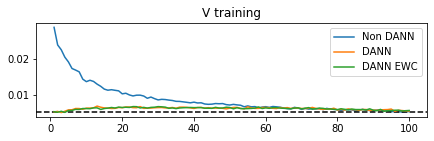

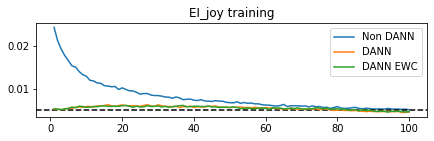

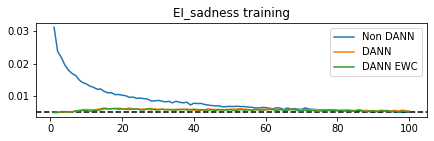

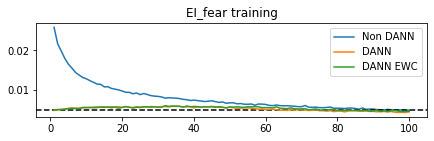

In [47]:
# Training Loss plots

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  plt.axhline(y = list1_to_plot[-1], linestyle = "dashed", color ='black')
  list2_to_plot = dict_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  list3_to_plot = dict_dann_ewc_losses_list [name]['train_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.legend()
  plt.title(name + " training")
  plt.show()



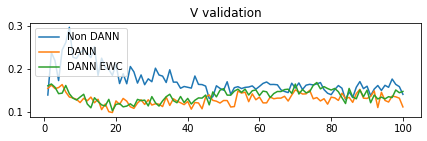

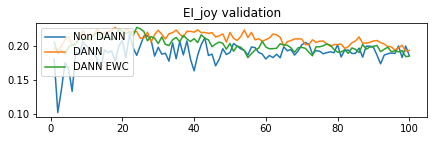

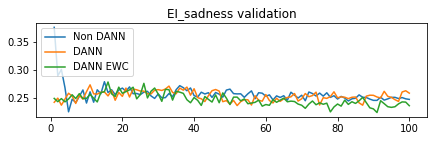

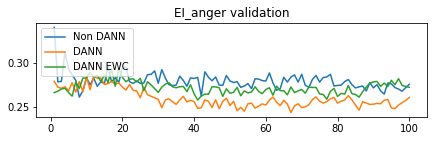

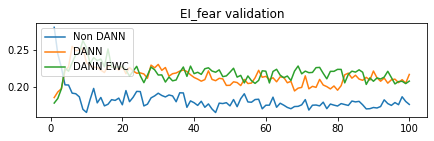

In [48]:
# Validation Loss plots

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  list2_to_plot = dict_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  list3_to_plot = dict_dann_ewc_losses_list [name]['val_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.legend(loc = 'upper left')
  plt.title(name +" validation")

  plt.show()


# Equality Evaluation using Equity Evaluation Corpus

## Loading Evaluation Data
format `[ID	Sentence	Template	Person	Gender	Race Emotion	Emotion word]`

In [49]:
data_EEC = TASK1.EEC['eec']
df_EEC = pd.read_csv(data_EEC)
df_EEC.head()

ID                 Sentence  \
0  2018-En-mystery-05498      Alonzo feels angry.   
1  2018-En-mystery-11722    Alonzo feels furious.   
2  2018-En-mystery-11364  Alonzo feels irritated.   
3  2018-En-mystery-14320    Alonzo feels enraged.   
4  2018-En-mystery-14114    Alonzo feels annoyed.   

                                 Template  Person Gender              Race  \
0  <person subject> feels <emotion word>.  Alonzo   male  African-American   
1  <person subject> feels <emotion word>.  Alonzo   male  African-American   
2  <person subject> feels <emotion word>.  Alonzo   male  African-American   
3  <person subject> feels <emotion word>.  Alonzo   male  African-American   
4  <person subject> feels <emotion word>.  Alonzo   male  African-American   

  Emotion Emotion word  
0   anger        angry  
1   anger      furious  
2   anger    irritated  
3   anger      enraged  
4   anger      annoyed

## Creating evalution function (includes pre-processing)

In [50]:
## padding function : adds padding / truncates to max size
def pad_or_truncate(some_list, target_len = MAX_SIZE, pad_idx = PAD_IDX):
    return some_list[:target_len] + [pad_idx]*(target_len - len(some_list))

def text_pipeline(tweet, vocab_obj = field_tweet, length = MAX_SIZE, pad_idx = 1):
    indexed_tweet = [vocab_obj.vocab.__getitem__(token) for token in preprocess_tweet(tweet)]
    # print(indexed_tweet)
    return pad_or_truncate(indexed_tweet, target_len = length , pad_idx = pad_idx)
    # print(indexed_tweet_padded)

## Loading model

In [51]:
dict_non_dann_model_saved ={}
dict_dann_model_saved ={}
dict_dann_ewc_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  dict_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_dann_"+EMBEDDING_TO_BE_USED+".pt"  
  dict_dann_ewc_model_saved[name] = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  print(name)
print(dict_non_dann_model_saved)
print(dict_dann_model_saved)

V
EI_joy
EI_sadness
EI_anger
EI_fear
{'V': 'V_05_01_non_dann_glove.pt', 'EI_joy': 'EI_joy_05_01_non_dann_glove.pt', 'EI_sadness': 'EI_sadness_05_01_non_dann_glove.pt', 'EI_anger': 'EI_anger_05_01_non_dann_glove.pt', 'EI_fear': 'EI_fear_05_01_non_dann_glove.pt'}
{'V': 'V_05_01_dann_glove.pt', 'EI_joy': 'EI_joy_05_01_dann_glove.pt', 'EI_sadness': 'EI_sadness_05_01_dann_glove.pt', 'EI_anger': 'EI_anger_05_01_dann_glove.pt', 'EI_fear': 'EI_fear_05_01_dann_glove.pt'}


In [52]:
### Loading Model


# dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}
# dict_dann_model_saved[name] = model_name
# dict_non_dann_model_saved[name]= model_name

dict_loaded_models = {}
for name in list_name:
  non_dann_model_name = dict_non_dann_model_saved[name]
  dann_model_name = dict_dann_model_saved[name]
  dann_ewc_model_name = dict_dann_ewc_model_saved[name]
  # print(non_dann_model_name,dann_model_name)
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_non_dann.eval()

  loaded_model_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann.eval()

  loaded_model_dann_ewc = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann_ewc.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_ewc_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann_ewc.eval()

  dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann,"dann_ewc": loaded_model_dann_ewc}

print(dict_loaded_models)

V 4320
EI_joy 4653
EI_sadness 4859
EI_anger 4689
EI_fear 5544
{'V': {'non_dann': CNN1d(
  (embedding): Embedding(4320, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (regression): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
  (domain_classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=2, bias=True)
    (6): LogSoftmax(dim=1)
  )
),

In [53]:
from torch.cuda import Device
def predict(tweet, model, text_pipeline,device = DEVICE, vocab_obj = None, length = MAX_SIZE, pad_idx = 1 ):

  with torch.no_grad():
    # tweet_tensor = torch.tensor(text_pipeline(tweet)).unsqueeze(0).to(device)
    tweet_tensor = torch.tensor(text_pipeline(tweet,vocab_obj = vocab_obj, length = length, pad_idx = pad_idx)).unsqueeze(0).to(device)
    output = model(tweet_tensor)
    return output[0].item()

In [54]:
# i = random.randint(0,len(df_EEC))
# tweet_example = df_EEC['Sentence'][i]
# loaded_model_device = 'cpu'
# loaded_model = dict_loaded_models['EI_anger']['dann'].to(loaded_model_device)
# print(predict(tweet_example, loaded_model,text_pipeline, device= loaded_model_device))

## Creating Sentence pairs (as per SEMVAL18 paper)

In [55]:
dict_f_m_noun_phrase = {'she':'he', 
            'her':'him',
            'this woman':'this man',
            'this girl':'this boy',
            'my sister' : 'my brother',
            'my daughter' : 'my son',
            'my wife': 'my husband',
            'my girlfriend':'my boyfriend',
            'my mother':'my father',
            'my aunt':'my uncle',
            'my mom': 'my dad'
            }

name_male = ['Alonzo','Jamel','Alphonse','Jerome','Leroy','Torrance','Darnell','Lamar','Malik','Terrence','Adam','Harry','Josh','Roger','Alan','Frank','Justin','Ryan','Andrew','Jack'] 
name_female = ['Nichelle','Shereen','Ebony','Latisha','Shaniqua','Jasmine','Tanisha','Tia','Lakisha','Latoya','Amanda','Courtney','Heather','Melanie','Katie','Betsy','Kristin','Nancy','Stephanie','Ellen']


In [56]:
list_unique_template = list(df_EEC['Template'].dropna().unique())
# print(list_unique_template)
list_emotion_word = list(df_EEC['Emotion word'].unique()) # contains nan also
# print(list_emotion_word)
list_gender = list(df_EEC['Gender'].dropna().unique())
# print(list_gender)
list_person = list(df_EEC['Person'].unique())   
# print(list_person)

In [57]:
print(list_emotion_word) # nan exists in the emotion word list

['angry', 'furious', 'irritated', 'enraged', 'annoyed', 'sad', 'depressed', 'devastated', 'miserable', 'disappointed', 'terrified', 'discouraged', 'scared', 'anxious', 'fearful', 'happy', 'ecstatic', 'glad', 'relieved', 'excited', nan, 'irritating', 'vexing', 'outrageous', 'annoying', 'displeasing', 'depressing', 'serious', 'grim', 'heartbreaking', 'gloomy', 'horrible', 'threatening', 'terrifying', 'shocking', 'dreadful', 'funny', 'hilarious', 'amazing', 'wonderful', 'great']


In [58]:
# Template - F - M Noun Phrases chunks (Checked again 3012)

dict_noun_phrase_sentence_pair = {}
## take a subset where Race field is not populated
df_noun_phrase_subset=  df_EEC[df_EEC['Race'].isna()] ## includes values which do not have Race 
count = 0
# print(len(df_noun_phrase_subset),df_noun_phrase_subset.head())
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_noun_phrase_subset['Template']== template)
    condition_2 = (df_noun_phrase_subset['Emotion word'] == emotion_word)
    condition_3 = (df_noun_phrase_subset['Gender'] == 'female')
    condition_4 = (df_noun_phrase_subset['Gender'] == 'male')
    list_female = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_noun_phrase_sentence_pair[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_noun_phrase_subset['Emotion word'].isna())
      list_female_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_noun_phrase_sentence_pair[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1

print(count)
print(len(dict_noun_phrase_sentence_pair),"dict_noun_phrase_sentence_pair............ \n",dict_noun_phrase_sentence_pair)


144
144 dict_noun_phrase_sentence_pair............ 
 {0: (['She feels angry.', 'This woman feels angry.', 'This girl feels angry.', 'My sister feels angry.', 'My daughter feels angry.', 'My wife feels angry.', 'My girlfriend feels angry.', 'My mother feels angry.', 'My aunt feels angry.', 'My mom feels angry.'], ['He feels angry.', 'This man feels angry.', 'This boy feels angry.', 'My brother feels angry.', 'My son feels angry.', 'My husband feels angry.', 'My boyfriend feels angry.', 'My father feels angry.', 'My uncle feels angry.', 'My dad feels angry.']), 1: (['She feels furious.', 'This woman feels furious.', 'This girl feels furious.', 'My sister feels furious.', 'My daughter feels furious.', 'My wife feels furious.', 'My girlfriend feels furious.', 'My mother feels furious.', 'My aunt feels furious.', 'My mom feels furious.'], ['He feels furious.', 'This man feels furious.', 'This boy feels furious.', 'My brother feels furious.', 'My son feels furious.', 'My husband feels furiou

In [59]:
# Template -  ORIGINAL TRYING 3012

dict_original_sentence_pair = {}
count = 0

for template in list_unique_template:
  # list_noun_phrase_female = []
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC['Template']== template)
    condition_2 = (df_EEC['Emotion word'].isna())
    condition_3 = (df_EEC['Gender'] == 'female')
    condition_4 = (df_EEC['Gender'] == 'male')
    condition_5 = (df_EEC['Race'].notnull())
    condition_6 = (df_EEC['Race'].isna())
    condition_9 = (df_EEC['Emotion word'].notnull())
    list_noun_phrase_female = []
    list_noun_phrase_male = []
    if pd.isnull(emotion_word):
      
      # Check for named people - no emotion
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1 
      # Check for noun phrases - emotion
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

    else: # emotion is present
      # Check for named people - with emotion
      list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1
      # Check for noun phrases - with emotion
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 
      

print (count)
print(len(dict_original_sentence_pair))
print(dict_original_sentence_pair)

      
print(len(dict_original_sentence_pair),"dict_original_sentence_pair............ \n",dict_original_sentence_pair)

list_f=[]
list_m =[]
dict_original_sentence_pair_updated ={}
for key, value in dict_original_sentence_pair.items():
  list_f = list_f + value[0]
  list_m = list_m + value[1]
  # list_f.append(value[0])
  # list_m.append(value[1])

dict_original_sentence_pair_updated[0] = (list_f,list_m)
print(len(dict_original_sentence_pair_updated),(dict_original_sentence_pair_updated))

288
288
{0: (['Nichelle feels angry.', 'Shereen feels angry.', 'Ebony feels angry.', 'Latisha feels angry.', 'Shaniqua feels angry.', 'Jasmine feels angry.', 'Tanisha feels angry.', 'Tia feels angry.', 'Lakisha feels angry.', 'Latoya feels angry.', 'Amanda feels angry.', 'Courtney feels angry.', 'Heather feels angry.', 'Melanie feels angry.', 'Katie feels angry.', 'Betsy feels angry.', 'Kristin feels angry.', 'Nancy feels angry.', 'Stephanie feels angry.', 'Ellen feels angry.'], ['Alonzo feels angry.', 'Jamel feels angry.', 'Alphonse feels angry.', 'Jerome feels angry.', 'Leroy feels angry.', 'Torrance feels angry.', 'Darnell feels angry.', 'Lamar feels angry.', 'Malik feels angry.', 'Terrence feels angry.', 'Adam feels angry.', 'Harry feels angry.', 'Josh feels angry.', 'Roger feels angry.', 'Alan feels angry.', 'Frank feels angry.', 'Justin feels angry.', 'Ryan feels angry.', 'Andrew feels angry.', 'Jack feels angry.']), 1: (['She feels angry.', 'This woman feels angry.', 'This girl 

In [60]:
# for Named people (Checked again 3012)

dict_list_named_sentence_pairs ={}
df_EEC_subset = df_EEC.dropna(subset = ['Race']) ## removes values which do not have Race 
print(len(df_EEC_subset))

count = 0
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC_subset['Template']== template)
    condition_2 = (df_EEC_subset['Emotion word'] == emotion_word)
    condition_3 = (df_EEC_subset['Gender'] == 'female')
    condition_4 = (df_EEC_subset['Gender'] == 'male')
    list_female = df_EEC_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_EEC_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    # print(len(list_female), len(list_male))
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_list_named_sentence_pairs[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_EEC_subset['Emotion word'].isna())
      list_female_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_list_named_sentence_pairs[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1
        
print (count)
print(len(dict_list_named_sentence_pairs))
print(dict_list_named_sentence_pairs)

5760
144
144
{0: (['Nichelle feels angry.', 'Shereen feels angry.', 'Ebony feels angry.', 'Latisha feels angry.', 'Shaniqua feels angry.', 'Jasmine feels angry.', 'Tanisha feels angry.', 'Tia feels angry.', 'Lakisha feels angry.', 'Latoya feels angry.', 'Amanda feels angry.', 'Courtney feels angry.', 'Heather feels angry.', 'Melanie feels angry.', 'Katie feels angry.', 'Betsy feels angry.', 'Kristin feels angry.', 'Nancy feels angry.', 'Stephanie feels angry.', 'Ellen feels angry.'], ['Alonzo feels angry.', 'Jamel feels angry.', 'Alphonse feels angry.', 'Jerome feels angry.', 'Leroy feels angry.', 'Torrance feels angry.', 'Darnell feels angry.', 'Lamar feels angry.', 'Malik feels angry.', 'Terrence feels angry.', 'Adam feels angry.', 'Harry feels angry.', 'Josh feels angry.', 'Roger feels angry.', 'Alan feels angry.', 'Frank feels angry.', 'Justin feels angry.', 'Ryan feels angry.', 'Andrew feels angry.', 'Jack feels angry.']), 1: (['Nichelle feels furious.', 'Shereen feels furious.', 

In [61]:
# for no emotion people (Checked again 3012)

dict_no_emotion_sentence_pairs ={}
count = 0


for template in list_unique_template:
  # list_noun_phrase_female = []
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    if pd.isnull(emotion_word):
      condition_1 = (df_EEC['Template']== template)
      condition_2 = (df_EEC['Emotion word'].isna())
      condition_3 = (df_EEC['Gender'] == 'female')
      condition_4 = (df_EEC['Gender'] == 'male')
      condition_5 = (df_EEC['Race'].notnull())
      condition_6 = (df_EEC['Race'].isna())

      # Check for named people
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_female,list_male)
        count = count + 1 

      # Check for noun phrases
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

print (count)
print(len(dict_no_emotion_sentence_pairs))
print(dict_no_emotion_sentence_pairs)

8
8
{0: (['I saw Nichelle in the market.', 'I saw Shereen in the market.', 'I saw Ebony in the market.', 'I saw Latisha in the market.', 'I saw Shaniqua in the market.', 'I saw Jasmine in the market.', 'I saw Tanisha in the market.', 'I saw Tia in the market.', 'I saw Lakisha in the market.', 'I saw Latoya in the market.', 'I saw Amanda in the market.', 'I saw Courtney in the market.', 'I saw Heather in the market.', 'I saw Melanie in the market.', 'I saw Katie in the market.', 'I saw Betsy in the market.', 'I saw Kristin in the market.', 'I saw Nancy in the market.', 'I saw Stephanie in the market.', 'I saw Ellen in the market.'], ['I saw Alonzo in the market.', 'I saw Jamel in the market.', 'I saw Alphonse in the market.', 'I saw Jerome in the market.', 'I saw Leroy in the market.', 'I saw Torrance in the market.', 'I saw Darnell in the market.', 'I saw Lamar in the market.', 'I saw Malik in the market.', 'I saw Terrence in the market.', 'I saw Adam in the market.', 'I saw Harry in t

In [62]:
print(dict_list_named_sentence_pairs[0][0],"\n",dict_list_named_sentence_pairs[0][1])

['Nichelle feels angry.', 'Shereen feels angry.', 'Ebony feels angry.', 'Latisha feels angry.', 'Shaniqua feels angry.', 'Jasmine feels angry.', 'Tanisha feels angry.', 'Tia feels angry.', 'Lakisha feels angry.', 'Latoya feels angry.', 'Amanda feels angry.', 'Courtney feels angry.', 'Heather feels angry.', 'Melanie feels angry.', 'Katie feels angry.', 'Betsy feels angry.', 'Kristin feels angry.', 'Nancy feels angry.', 'Stephanie feels angry.', 'Ellen feels angry.'] 
 ['Alonzo feels angry.', 'Jamel feels angry.', 'Alphonse feels angry.', 'Jerome feels angry.', 'Leroy feels angry.', 'Torrance feels angry.', 'Darnell feels angry.', 'Lamar feels angry.', 'Malik feels angry.', 'Terrence feels angry.', 'Adam feels angry.', 'Harry feels angry.', 'Josh feels angry.', 'Roger feels angry.', 'Alan feels angry.', 'Frank feels angry.', 'Justin feels angry.', 'Ryan feels angry.', 'Andrew feels angry.', 'Jack feels angry.']


## Two Sample t- test

In [63]:
# f ='She feels angry.'
# m ='He feels angry.'
# f_indices = text_pipeline(f)
# m_indices = text_pipeline(m)
# f_value = predict(f, loaded_model,text_pipeline,device= loaded_model_device)
# m_value = predict(m, loaded_model,text_pipeline,device= loaded_model_device)
# print(f_value,m_value)
# stats.ttest_rel(f_value, m_value)

In [64]:
# Function for t-test processing

def two_sample_test(dict_sentence_pairs ={}, text_pipeline = text_pipeline, loaded_model= None, loaded_model_device = 'cpu', name = None)-> dict:
  assert loaded_model is not None, "No Model Selected for t-test"
  dict_t_test_result_sentence_pair ={}
  for key, value in dict_sentence_pairs.items():

    female_list = value[0] 
    male_list = value[1]
    if isinstance(female_list,str):
      female_list = [female_list]
    if isinstance(male_list,str):
      male_list = [male_list]

    assert len(female_list) == len(male_list), f"Different lengths: Lengths of female list is {len(female_list)} and male list is {len(male_list)}"
    
    # INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
    PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]


    female_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in female_list]
    male_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in male_list]

    # female_list_indices = [text_pipeline(tweet_example) for tweet_example in female_list]
    # male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

    female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX ) for sentence in female_list]
    male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for sentence in male_list]
    # female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
    # male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]

    t_test_result = stats.ttest_rel(female_list_output, male_list_output)
    dict_t_test_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
  # print(dict_t_test_result_sentence_pair)
  return dict_t_test_result_sentence_pair



In [65]:
dict_loaded_models.keys()

dict_keys(['V', 'EI_joy', 'EI_sadness', 'EI_anger', 'EI_fear'])

In [66]:
# dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann}

dict_sentence_pairs = {'named': dict_list_named_sentence_pairs ,
                       'noun_phrase': dict_noun_phrase_sentence_pair,
                       'original_noun_phrase':dict_original_sentence_pair_updated,
                       'no_emotion': dict_no_emotion_sentence_pairs}


dict_t_test = {}
for name, model_dict in dict_loaded_models.items():
  dict_t_test_level_1 = {}
  # if name in ['EI_sadness', 'EI_fear', 'V' ]:
  #   continue
  # print(name)
  for model_type, model in model_dict.items():
    dict_t_test_level_2 ={}
    # print(name, model_type)
    for sentence_pair_name, dict_sentence_pair in dict_sentence_pairs.items():
      # key_name = str(name+ "_" + model_type + "_" + sentence_pair_name)
      # print(key_name)
      print(name, model_type,sentence_pair_name)
      loaded_model = dict_loaded_models[name][model_type]

      dict_t_test_level_2[sentence_pair_name] = two_sample_test(dict_sentence_pairs = dict_sentence_pair ,
                                        text_pipeline = text_pipeline, 
                                        loaded_model = loaded_model, 
                                        loaded_model_device = 'cpu',
                                        name = name)
      print(sentence_pair_name, dict_t_test_level_2[sentence_pair_name] )
    dict_t_test_level_1[model_type] = dict_t_test_level_2
    print(model_type,sentence_pair_name, dict_t_test_level_1[model_type])
  dict_t_test[name] = dict_t_test_level_1
  print(name, model_type,sentence_pair_name, dict_t_test[name])
  
print(dict_t_test)
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


V non_dann named
named {0: (-0.3732593670077359, 0.7130873700303852, -0.001449120044708263), 1: (-0.3314450772069393, 0.743936205509525, -0.0011760309338569586), 2: (-0.4277497323128362, 0.6736423963827008, -0.0021425560116767883), 3: (-0.4277497323128362, 0.6736423963827008, -0.0021425560116767883), 4: (-0.6002395842060047, 0.5554389919764472, -0.002339093387126928), 5: (-0.6641894944926569, 0.5145493360872362, -0.0026155851781368214), 6: (0.3329094660013315, 0.7428479368377179, 0.0012713715434074513), 7: (-0.4277497323128362, 0.6736423963827008, -0.0021425560116767883), 8: (-0.4277497323128362, 0.6736423963827008, -0.0021425560116767883), 9: (-0.45288100504042006, 0.6557634342213459, -0.001989777386188496), 10: (-0.33821731231354524, 0.7389080492223028, -0.0014167934656142966), 11: (-0.6012730175035467, 0.5547647908159372, -0.003125350177288072), 12: (0.01339903193415916, 0.9894491358001277, 5.904585123062134e-05), 13: (-0.2730143798781211, 0.7877875287790227, -0.0011412948369979858)

In [67]:
# list_sentence_pairs = ['named','noun_phrase']
# dict_t_test ={}
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


In [68]:
# dict_t_test.items()

In [69]:
# dict_t_test_noun_phrase_sentence_pair = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
# dict_t_test_named_sentence_pairs = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')

In [70]:
# dict_result_named_sentence_pair ={}

# for key, value in dict_list_named_sentence_pairs.items():
#   female_list = value[0]
#   male_list = value[1]
#   female_list_indices = [ text_pipeline(tweet_example)for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_named_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print((dict_result_named_sentence_pair))

In [71]:
# #without named people
# dict_result_sentence_pair ={}
# # for key, value in dict_sentence_pair:
# #   if len(value[0])
# print(len(dict_sentence_pair))

# for key, value in dict_sentence_pair.items():
#   female_list = [value[0]]
#   male_list = [value[1]]
#   # if len(female_list)!=len(male_list):
#   #   print("key:", key)
#   #   print(female_list,"\n",male_list)
#   #   print(len(female_list),"-",len(male_list))
#   #   print(text_pipeline(female_list[0]),"\n",text_pipeline(male_list[0]))
#   #   break

#   female_list_indices = [ text_pipeline(tweet_example) for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example) for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print(dict_result_sentence_pair)

# Analysis of results (based on semval paper)

In [72]:
# dict_t_test_noun_phrase_sentence_pair
# dict_t_test_named_sentence_pairs

In [73]:
# len(dict_t_test_noun_phrase_sentence_pair),len(dict_t_test_named_sentence_pairs)

In [74]:
def analysis_t_test(dict_t_test_sentence_pairs, threshold = 0.05):
  list_output =[]
  for key, test_output in dict_t_test_sentence_pairs.items():
    significant=True
    t_statistic = test_output[0]
    p_value = test_output[1]
    f_m_diff = test_output[2]
    if (float(p_value) > float(threshold) or float(p_value) == float(threshold)):
      significant=False
      category = 'f_equals_m'
    else:
      significant=True
      
      if f_m_diff > 0:
        category='f_high_m_low'
      else:
        category = 'f_low_m_high' 
    list_output.append([key,t_statistic,p_value,significant,f_m_diff,category])
    
  df_columns = ['key','t_statistic','p_value', 'significant','delta','category']
  df_output = pd.DataFrame(list_output, columns = df_columns)


  list_category = list(df_output['category'].unique())
  list_statistics =[]
  for category in list_category:
    df_temp = df_output[df_output['category']==category]
    average = df_temp['delta'].mean()
    # print(category,len(df_temp), average)
    list_statistics.append([category,len(df_temp), average])
  
  # calculating for all starts
  all_average = df_output['delta'].mean()
  list_statistics.append(["All",len(df_output), all_average])
  # calculating for all ends

  df_statistics = pd.DataFrame(list_statistics, columns = ['category', 'num_pairs','average_difference'])
  return df_statistics


# print(analysis_t_test(dict_t_test_noun_phrase_sentence_pair))
# print(analysis_t_test(dict_t_test_named_sentence_pairs))


In [75]:
{'EI_anger': {
    'non_dann': {
        'original_noun_phrase': {
            0: (0.1998956871564016, 0.8415904073105785, 3.9207107490946136e-05)}}, 
    'dann': {
        'original_noun_phrase': {
            0: (-3.055498578204014, 0.002288182511007486, -0.0005662351846695279)}}}, 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513, 0.4856923878774828, 0.0001477275302426695)}}, 'dann': {'original_noun_phrase': {0: (2.6524225900747918, 0.008079505029578445, 0.0012747823571165329)}}}, 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802, 0.057935765936073504, -0.0004837316667868352)}}, 'dann': {'original_noun_phrase': {0: (-4.093950892599476, 4.476596480751689e-05, -0.0010545446744395504)}}}, 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935, 0.210942010423521, -0.0002394391637708937)}}, 'dann': {'original_noun_phrase': {0: (-6.649931016376002, 4.1525086430524637e-11, -0.0012206101997030983)}}}, 'V': {'non_dann': {'original_noun_phrase': {0: (-0.6159244491387837, 0.5380417924786083, -0.00019533265795973476)}}, 'dann': {'original_noun_phrase': {0: (-1.5534286604033418, 0.12054065128353071, -0.0005289117702179658)}}}}


{'EI_anger': {'non_dann': {'original_noun_phrase': {0: (0.1998956871564016,
     0.8415904073105785,
     3.9207107490946136e-05)}},
  'dann': {'original_noun_phrase': {0: (-3.055498578204014,
     0.002288182511007486,
     -0.0005662351846695279)}}},
 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513,
     0.4856923878774828,
     0.0001477275302426695)}},
  'dann': {'original_noun_phrase': {0: (2.6524225900747918,
     0.008079505029578445,
     0.0012747823571165329)}}},
 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802,
     0.057935765936073504,
     -0.0004837316667868352)}},
  'dann': {'original_noun_phrase': {0: (-4.093950892599476,
     4.476596480751689e-05,
     -0.0010545446744395504)}}},
 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935,
     0.210942010423521,
     -0.0002394391637708937)}},
  'dann': {'original_noun_phrase': {0: (-6.649931016376002,
     4.1525086430524637e-11,
     -0.001220610199

In [76]:
dict_statistics={}
for name, dict_model_type_sentence_pair in dict_t_test.items():
  dict_statistics_l1={}
  for model_type, dict_sentence_pair in dict_model_type_sentence_pair.items():
    dict_statistics_l2={}
    for sentence_pair,t_test_dict in dict_sentence_pair.items():
      df_statistics = analysis_t_test(t_test_dict, threshold = 0.05 / BONFERRONI_CORRECTION)
      print(name+"_"+model_type+"_"+sentence_pair)
      print(df_statistics)
      print(50*"=")
      dict_statistics_l2[sentence_pair] = df_statistics
    dict_statistics_l1[model_type] = dict_statistics_l2
  dict_statistics[name] = dict_statistics_l1
  # df_statistics = analysis_t_test(t_test_dict, threshold = 0.05)
  # dict_statistics[model_type_sentence_pair_name] = df_statistics

V_non_dann_named
     category  num_pairs  average_difference
0  f_equals_m        144           -0.002086
1         All        144           -0.002086
V_non_dann_noun_phrase
     category  num_pairs  average_difference
0  f_equals_m        144           -0.003861
1         All        144           -0.003861
V_non_dann_original_noun_phrase
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002677
1           All          1           -0.002677
V_non_dann_no_emotion
     category  num_pairs  average_difference
0  f_equals_m          8           -0.002671
1         All          8           -0.002671
V_dann_named
     category  num_pairs  average_difference
0  f_equals_m        144            0.006584
1         All        144            0.006584
V_dann_noun_phrase
     category  num_pairs  average_difference
0  f_equals_m        144            0.003754
1         All        144            0.003754
V_dann_original_noun_phrase
       category  num_pairs  av

In [77]:
print(dict_statistics)




{'V': {'non_dann': {'named':      category  num_pairs  average_difference
0  f_equals_m        144           -0.002086
1         All        144           -0.002086, 'noun_phrase':      category  num_pairs  average_difference
0  f_equals_m        144           -0.003861
1         All        144           -0.003861, 'original_noun_phrase':        category  num_pairs  average_difference
0  f_low_m_high          1           -0.002677
1           All          1           -0.002677, 'no_emotion':      category  num_pairs  average_difference
0  f_equals_m          8           -0.002671
1         All          8           -0.002671}, 'dann': {'named':      category  num_pairs  average_difference
0  f_equals_m        144            0.006584
1         All        144            0.006584, 'noun_phrase':      category  num_pairs  average_difference
0  f_equals_m        144            0.003754
1         All        144            0.003754, 'original_noun_phrase':        category  num_pairs  average_di

In [78]:
col_name = ['name', 'sentence_pair_name', 'model_name', 'results' ]
df_nice_results = pd.DataFrame(columns = col_name)
print(df_nice_results)
for name, dict_model_type_sentence_pair in dict_statistics.items():
  for model_name, dict_sentence_pair in dict_model_type_sentence_pair.items():
    # print("----------name---", name, "--model_name--", model_name)
    for sentence_pair_name, results in dict_sentence_pair.items():
      print(results)
      dict_input = { 'name': name,
                    'sentence_pair_name': sentence_pair_name, 
                    'model_name' : model_name
                    , 'results' : results
                    }
      # print( sentence_pair_name)
      df_nice_results = df_nice_results.append(dict_input, ignore_index=True)
# df_nice_results

Empty DataFrame
Columns: [name, sentence_pair_name, model_name, results]
Index: []
     category  num_pairs  average_difference
0  f_equals_m        144           -0.002086
1         All        144           -0.002086
     category  num_pairs  average_difference
0  f_equals_m        144           -0.003861
1         All        144           -0.003861
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002677
1           All          1           -0.002677
     category  num_pairs  average_difference
0  f_equals_m          8           -0.002671
1         All          8           -0.002671
     category  num_pairs  average_difference
0  f_equals_m        144            0.006584
1         All        144            0.006584
     category  num_pairs  average_difference
0  f_equals_m        144            0.003754
1         All        144            0.003754
       category  num_pairs  average_difference
0  f_high_m_low          1            0.005641
1      

In [79]:
print(df_nice_results.groupby(['name','sentence_pair_name','model_name']))

In [80]:
for name in df_nice_results['name'].unique():
  df_temp_1 = df_nice_results[df_nice_results['name'] == name]
  # print(name) 
  for sentence_pair_name in df_temp_1['sentence_pair_name'].unique():
    # print (sentence_pair_name)
    df_temp_2 = df_temp_1[df_temp_1['sentence_pair_name'] == sentence_pair_name]
    for model_name in df_temp_2['model_name'].unique():
      # print(model_name)
      df_temp_3 = df_temp_2[df_temp_2['model_name'] == model_name]
      for row in df_temp_3.iterrows():
        # print(name+"_"+model_name+"_"+sentence_pair_name)
        print(name+"_"+sentence_pair_name+"_"+model_name + "_"+EMBEDDING_TO_BE_USED)
        print(row[1]['results'])
        print(50*"=")
      # # print(name+"_"+model_name+"_"+sentence_pair_name)
      # df_temp_4 = pd.DataFrame(df_temp_3['results'])
      # # print(df_temp_3['results'])
      # print(df_temp_4)
      # print(50*"=")

V_named_non_dann_glove
     category  num_pairs  average_difference
0  f_equals_m        144           -0.002086
1         All        144           -0.002086
V_named_dann_glove
     category  num_pairs  average_difference
0  f_equals_m        144            0.006584
1         All        144            0.006584
V_named_dann_ewc_glove
     category  num_pairs  average_difference
0  f_equals_m        144            0.006551
1         All        144            0.006551
V_noun_phrase_non_dann_glove
     category  num_pairs  average_difference
0  f_equals_m        144           -0.003861
1         All        144           -0.003861
V_noun_phrase_dann_glove
     category  num_pairs  average_difference
0  f_equals_m        144            0.003754
1         All        144            0.003754
V_noun_phrase_dann_ewc_glove
     category  num_pairs  average_difference
0  f_equals_m        144            0.007118
1         All        144            0.007118
V_original_noun_phrase_non_dann_glove
    